### This notebook is part #5 to reproduce the results of Bletery and Nocquet (Science, 2023)
It reads the files generated in the previous parts and generates the figures of the articles, which will be saved in fig_dir (='/figures').

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
import scipy.optimize
import pyeq.green.make

In [2]:
# Declare variables

nsample = 576
mu=29353000000 # shear modulus
L, W = 1, 1

data_byEQ_dir = 'data_byEQ'
leq_file = glob(data_byEQ_dir+"/20*_MW_*/dot_product_stack.txt")
fig_dir = 'figures'
TO_fig_dir = 'TO_source_test'

In [3]:
M = mu * L*1000 * W*1000 
t = [0]*nsample
for i in range(nsample):
    t[i] = -48 * (nsample-1-i)/nsample - 2.5/60 
nd = int(nsample/2)

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

if not os.path.exists(TO_fig_dir):
    os.makedirs(TO_fig_dir)

In [4]:
# Make the global stack

eq_stack, eq_stack_E, eq_stack_N, Nst, sg1, sg2, eq_dir  = [], [], [], [], [], [], []

for eq_file in leq_file:
    eq = eq_file.split('/')[-2]
    eq_dir.append(eq)
    eq_stack.append(np.genfromtxt(eq_file))
    eq_stack_E.append(np.genfromtxt(data_byEQ_dir+'/'+eq+'/dot_product_stack_E.txt'))
    eq_stack_N.append(np.genfromtxt(data_byEQ_dir+'/'+eq+'/dot_product_stack_N.txt'))
    sigmag2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmag2.txt'))
    sigmaj2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmaj2.txt'))
    Nst.append(len(sigmag2))
    if len(sigmag2)>1:
        sg1.append(sum(np.divide(np.sqrt(sigmag2),sigmaj2)))   
        sg2.append(sum(np.divide(sigmag2,sigmaj2)))
    else:
        sg1.append(float(np.divide(np.sqrt(sigmag2),sigmaj2)))
        sg2.append(float(np.divide(sigmag2,sigmaj2)))

stack = sum(eq_stack)
Sg = sum(sg2)
stack_moment = M * stack / Sg
stack_E, stack_N = sum(eq_stack_E) * Sg, sum(eq_stack_N) * Sg

print(str(len(eq_stack))+' earthquakes in the stack')
print(str(sum(Nst))+' stations')

90 earthquakes in the stack
3026 stations


Last point with negative stack is 1.92 hours before origin time


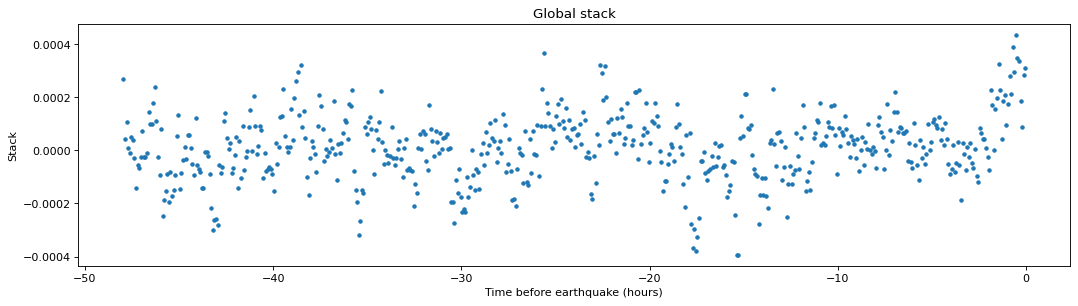

In [5]:
# Plot the global stack (Figure 2.a)

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack,'.')
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Stack')
plt.title('Global stack')
plt.savefig(fig_dir+'/Figure_2a.pdf')

I=np.where(stack<0)[0][-1]
tp = t[I]+2.5/60

print('Last point with negative stack is '+str(round(abs(tp),2))+' hours before origin time')

Last point of the moving average is 1.82 times larger than the maximum in the 2 days before
Last point of the moving average is 3.85 times larger than the standard deviation
The last 23 points of the moving average are monotonically increasing


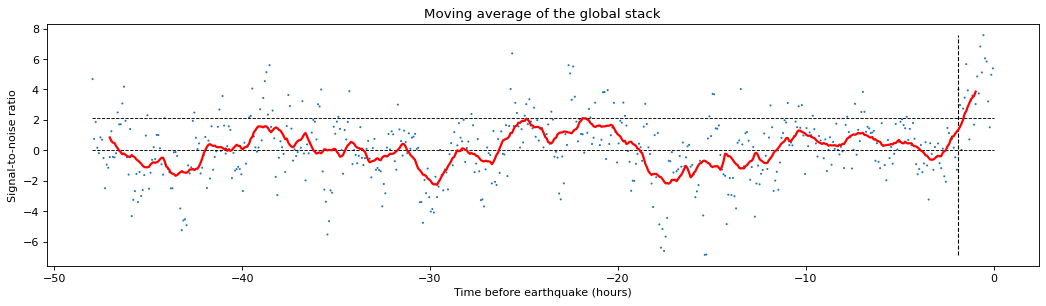

In [6]:
# Calculate a moving average (windows of 1h50min with wd=22) and plot it (Figure 2.b)

wd = 22 # window duration of the moving average (in samples)

Nsma = nsample - wd # number of samples in the moving average time series
N0 = Nsma - 24 # number of samples of the moving average unafected by the last 2 hours
SMA, tsma, Np = [0]*Nsma, [0]*Nsma, [0]*Nsma
for i in range(Nsma):
    SMA[i] = np.mean(stack[i:i+wd])
    tsma[i] = -48+(i+(1+wd)/2)*5/60

max_sma = max(SMA[0:N0]) # maximum of the moving average excluding the last 2 hours
std_sma = np.std(SMA[0:N0]) # standard deviation of the moving average excluding the last 2 hours

plt.figure(figsize=(16, 4), dpi=80)
plt.plot([-48,0],[0,0],'k--',linewidth=0.8)
plt.plot([-48,0],[max_sma,max_sma]/std_sma,'k--',linewidth=0.8)
plt.plot([tp,tp],[min(stack),max(stack)]/std_sma,'k--',linewidth=1)
plt.scatter(t,stack/std_sma,s=[0.7 for n in range(len(t))])
plt.plot(tsma,SMA/std_sma,'r-',linewidth=2)
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Signal-to-noise ratio')
plt.title('Moving average of the global stack')
plt.savefig(fig_dir+'/Figure_2b.pdf')

print('Last point of the moving average is '+str(round(SMA[-1]/max_sma,2))+' times larger than the maximum in the 2 days before')
print('Last point of the moving average is '+str(round(SMA[-1]/std_sma,2))+' times larger than the standard deviation')
print('The last '+str(Nsma - np.where(np.diff(SMA)<=0)[0][-1]-2)+' points of the moving average are monotonically increasing')

Last point of the moving median is 2.1 times larger than the maximum in the 2 days before
Last point of the moving median is 3.9 times larger than the standard deviation


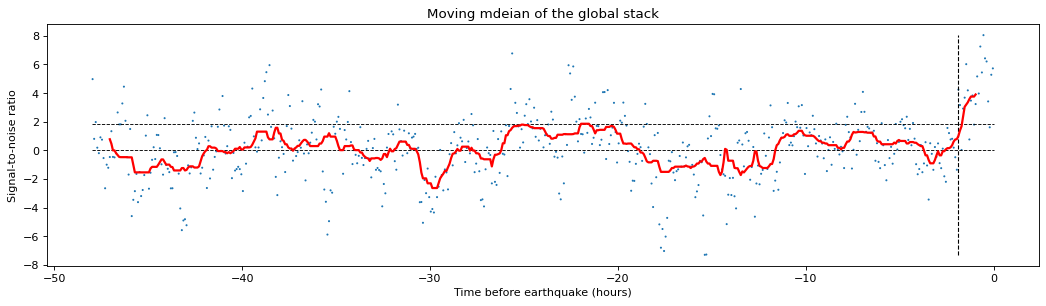

In [7]:
# Calculate a moving median (windows of 1h50min with wd=22) and plot it

Nsmm = nsample - wd # number of samples in the moving average time series
SMM = [0]*Nsmm
for i in range(Nsmm):
    SMM[i] = np.median(stack[i:i+wd])

max_smm = max(SMM[0:N0]) # maximum of the moving average excluding the last 2 hours
std_smm = np.std(SMM[0:N0]) # standard deviation of the moving average excluding the last 2 hours

plt.figure(figsize=(16, 4), dpi=80)
plt.plot([-48,0],[0,0],'k--',linewidth=0.8)
plt.plot([-48,0],[max_smm,max_smm]/std_smm,'k--',linewidth=0.8)
plt.plot([tp,tp],[min(stack),max(stack)]/std_smm,'k--',linewidth=1)
plt.scatter(t,stack/std_smm,s=[0.7 for n in range(len(t))])
plt.plot(tsma,SMM/std_smm,'r-',linewidth=2)
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Signal-to-noise ratio')
plt.title('Moving mdeian of the global stack')

print('Last point of the moving median is '+str(round(SMM[-1]/max_smm,2))+' times larger than the maximum in the 2 days before')
print('Last point of the moving median is '+str(round(SMM[-1]/std_smm,2))+' times larger than the standard deviation')

In [8]:
# Define functions to fit sinusoids and exponential functions 

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

def func(x, a, b, c):
    return a * np.exp(b * x) + c

Time constant of the exponenital fit: 1.27 h
Cumulative pre-seismic moment: 3.9e+18 N.m (corresponding to a moment magnitude Mw = 6.3)


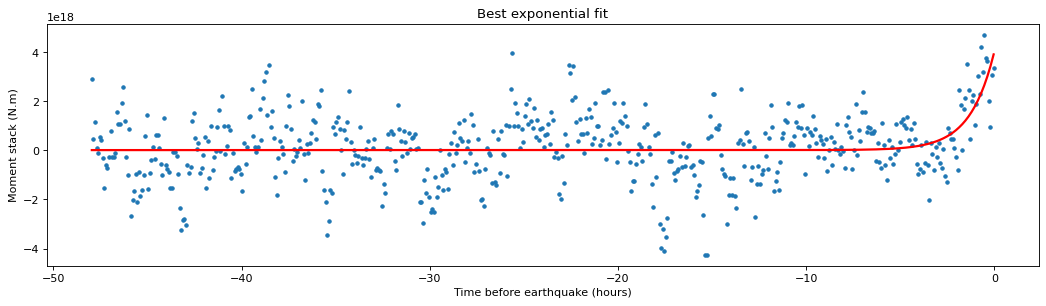

In [9]:
# Fit exponential and plot it (Figure 2.c)

popt, pcov = scipy.optimize.curve_fit(func, t, stack)
yexp = func(np.array(t), popt[0],popt[1],popt[2])
exp_fit = yexp*M/Sg

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack_moment,'.')
plt.plot(t,exp_fit, "r-", linewidth=2)
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Moment stack (N.m)')
plt.title('Best exponential fit')
plt.savefig(fig_dir+'/Figure_2c.pdf')

M0end = exp_fit[-1]
Mwend = (2/3)*np.log10(M0end)-6.07

print('Time constant of the exponenital fit: '+str(round(1/popt[1],2))+' h')
print('Cumulative pre-seismic moment: '+str(M0end)[0:3]+str(exp_fit[-1])[-4:len(str(exp_fit[-1]))]+' N.m (corresponding to a moment magnitude Mw = '+str(round(Mwend,1))+')') 

Period: 12.9 hours
Amplitude: 5.9e+17 N.m (corresponding to a moment magnitude Mw = 5.8)


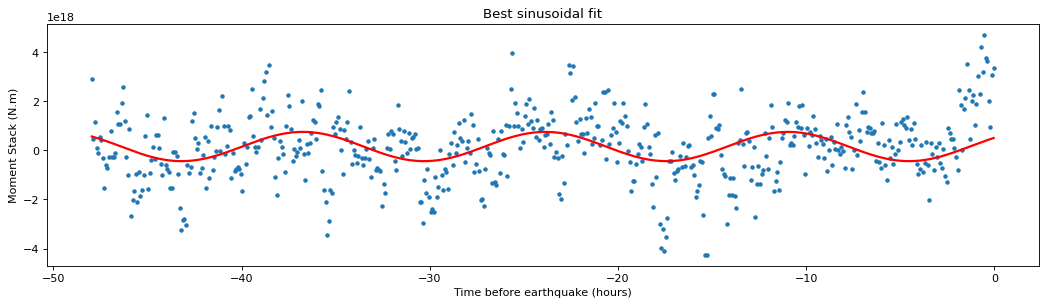

In [10]:
# Fit sinusoid and plot it (Figure 2.d)

res = fit_sin(t,stack_moment)
ysin = res["fitfunc"](np.array(t))

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack_moment,'.')
plt.plot(t,ysin, "r-", linewidth=2)
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Moment Stack (N.m)')
plt.title('Best sinusoidal fit')
plt.savefig(fig_dir+'/Figure_2d.pdf')

A = abs(res['amp'])
Mwsin = (2/3)*np.log10(A)-6.07

print('Period: '+str(round(res['period'],1))+' hours')
print('Amplitude: '+str(A)[0:3]+str(A)[-4:len(str(A))]+' N.m (corresponding to a moment magnitude Mw = '+str(round(Mwsin,1))+')')

In [11]:
# Calculate RMS reductions of the exponential and sinusoidal fits

rmsred_exp = 100*(np.linalg.norm(stack[-wd-1:-1])**2-np.linalg.norm(stack[-wd-1:-1]-yexp[-wd-1:-1])**2)/np.linalg.norm(stack[-wd-1:-1])**2
print('RMS reduction of the exponential fit in the last 1 h and 50 min: '+str(round(rmsred_exp))+'%')
rmsred_sin = 100*(np.linalg.norm(stack_moment)**2-np.linalg.norm(stack_moment-ysin)**2)/np.linalg.norm(stack_moment)**2
print('RMS reduction of the sinusoidal fit in the 48 h time period: '+str(round(rmsred_sin))+'%')

RMS reduction of the exponential fit in the last 1 h and 50 min: 79%
RMS reduction of the sinusoidal fit in the 48 h time period: 10%


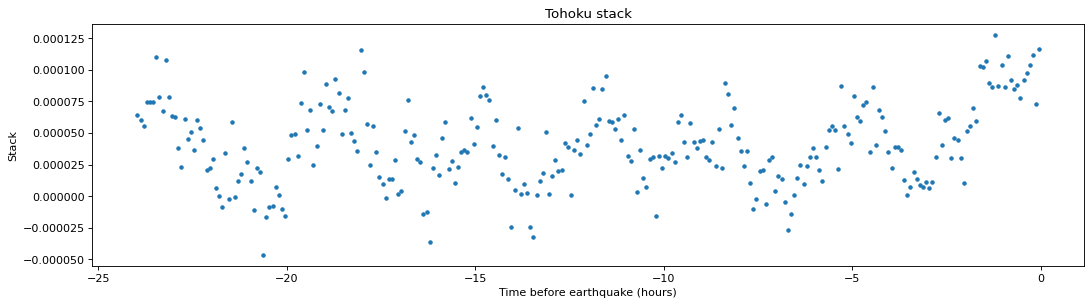

In [12]:
# Plot the dot product stack for the Tohoku-Oki earthquake (Figure 3.a)

I_TO = np.where(np.array(eq_dir)=='20110311T05:46:24_MW_9.0')[0][0]
t_TO, stack_TO = t[nd:nsample], eq_stack[I_TO][nd:nsample]

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t_TO,stack_TO,'.')
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Stack')
plt.title('Tohoku stack')
plt.savefig(fig_dir+'/Figure_3a.pdf')

Period: 3.6 hours
Amplitude: 1.0e+19 N.m (corresponding to a moment magnitude Mw = 6.6)
RMS reduction of the sinusoidal fit in the 24 h preceding the Tohoku earthquake: 72%


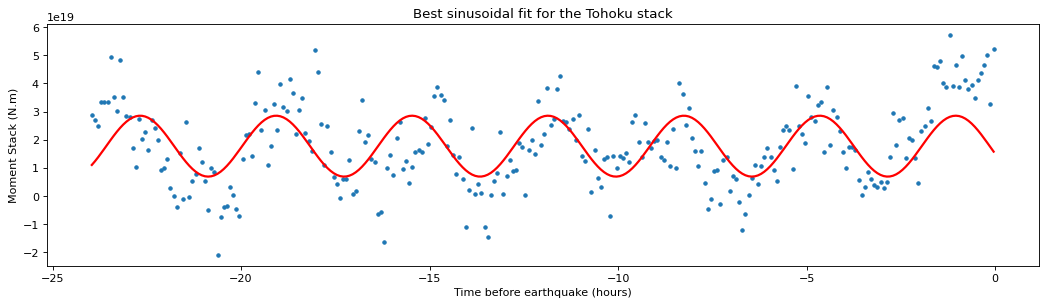

In [13]:
# Fit sinusoid and plot it for Tohoku (Figure 3.b)

stack_TO_moment = stack_TO*M/sg2[I_TO] # convert in moment
res = fit_sin(t_TO,stack_TO_moment)
ysin_TO = res["fitfunc"](np.array(t_TO))

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t_TO,stack_TO_moment,'.')
plt.plot(t_TO,ysin_TO, "r-", linewidth=2)
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Moment Stack (N.m)')
plt.title('Best sinusoidal fit for the Tohoku stack')
plt.savefig(fig_dir+'/Figure_3b.pdf')

A = abs(res['amp'])
Mwsin = (2/3)*np.log10(A)-6.07

print('Period: '+str(round(res['period'],1))+' hours')
print('Amplitude: '+str(A)[0:3]+str(A)[-4:len(str(A))]+' N.m (corresponding to a moment magnitude Mw = '+str(round(Mwsin,1))+')')

rmsred_TO = 100*(np.linalg.norm(stack_TO_moment)**2-np.linalg.norm(stack_TO_moment-ysin_TO)**2)/np.linalg.norm(stack_TO_moment)**2
print('RMS reduction of the sinusoidal fit in the 24 h preceding the Tohoku earthquake: '+str(round(rmsred_TO))+'%')

Time constant of the exponenital fit: 1.51 h
Cumulative pre-seismic moment: 2.9e+19 N.m (corresponding to a moment magnitude Mw = 6.9)


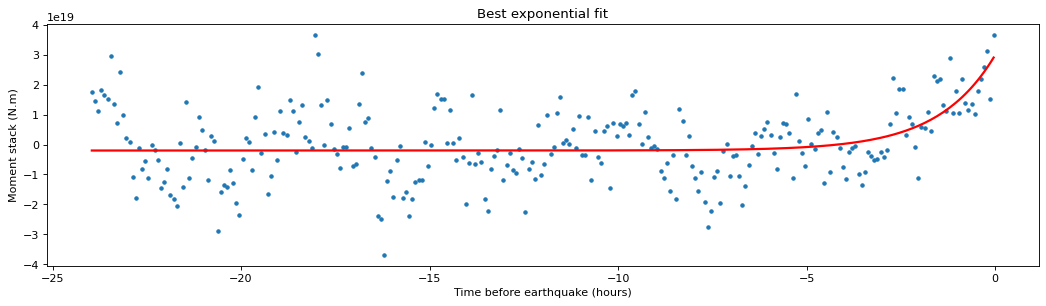

In [14]:
# Fit exponential and plot it for Tohoku (Figure 3.c)

stack_m_sin = stack_TO - ysin_TO*sg2[I_TO]/M # the fitting function does not handle numbers too large
popt_TO, pcov_TO = scipy.optimize.curve_fit(func, t_TO, stack_m_sin)
yexp_TO = func(np.array(t_TO), popt_TO[0],popt_TO[1],popt_TO[2])
exp_fit_TO = yexp_TO*M/sg2[I_TO]

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t_TO,stack_m_sin*M/sg2[I_TO],'.')
plt.plot(t_TO,exp_fit_TO, "r-", linewidth=2)
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Moment stack (N.m)')
plt.title('Best exponential fit')
plt.savefig(fig_dir+'/Figure_3c.pdf')

M0end_TO = exp_fit_TO[-1]
Mwend_TO = (2/3)*np.log10(M0end_TO)-6.07

print('Time constant of the exponenital fit: '+str(round(1/popt_TO[1],2))+' h')
print('Cumulative pre-seismic moment: '+str(M0end_TO)[0:3]+str(exp_fit_TO[-1])[-4:len(str(exp_fit_TO[-1]))]+' N.m (corresponding to a moment magnitude Mw = '+str(round(Mwend_TO,1))+')') 

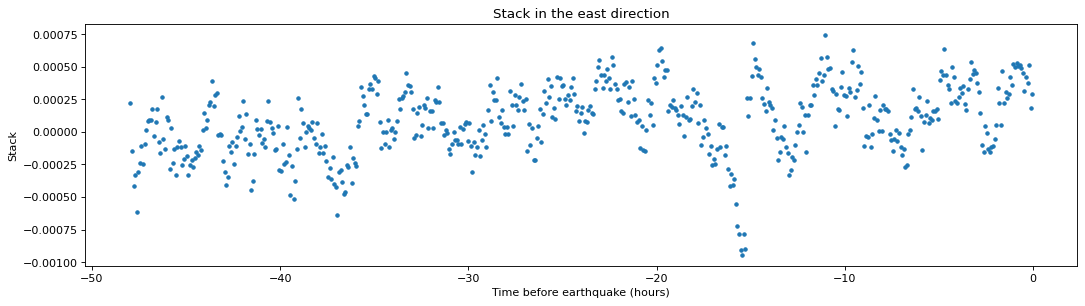

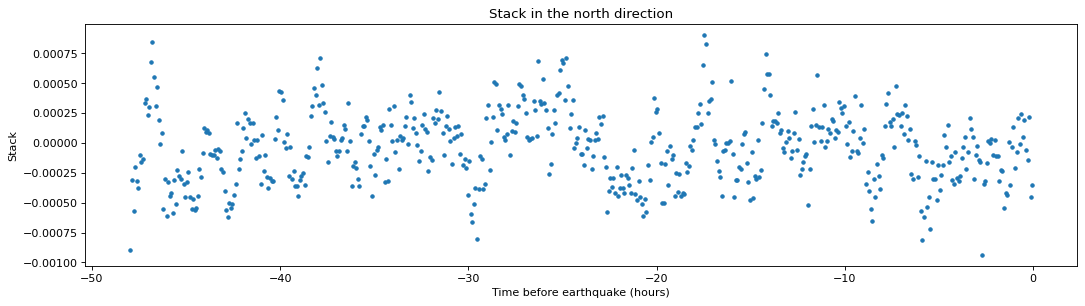

In [15]:
# Plot stack of dot product in the east and north directions (Figure S1)

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack_E,'.')
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Stack')
plt.title('Stack in the east direction')
plt.savefig(fig_dir+'/Figure_S1a.pdf')

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack_N,'.')
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Stack')
plt.title('Stack in the north direction')
plt.savefig(fig_dir+'/Figure_S1b.pdf')

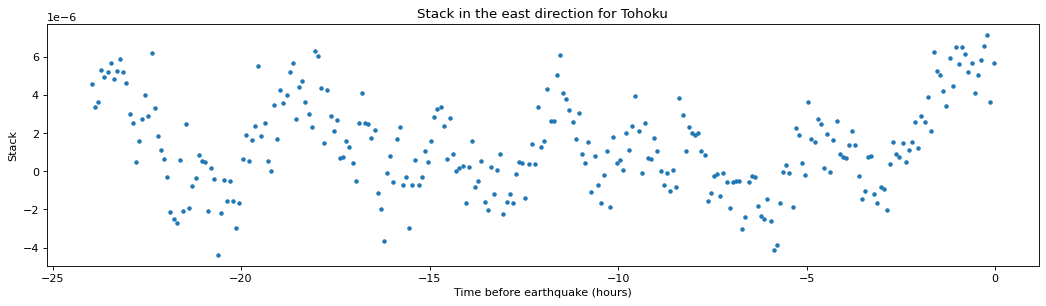

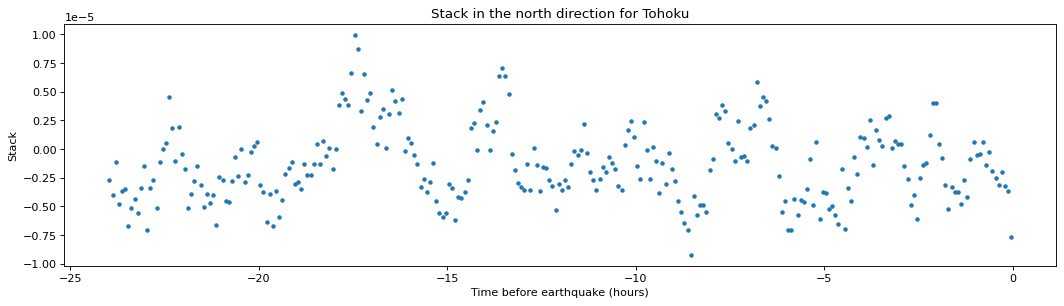

In [16]:
# Plot stack of dot product in the east and north directions for Tohoku (Figure S2)

stack_E_TO, stack_N_TO = eq_stack_E[I_TO][nd:nsample]*sg2[I_TO], eq_stack_N[I_TO][nd:nsample]*sg2[I_TO]

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t_TO,stack_E_TO,'.')
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Stack')
plt.title('Stack in the east direction for Tohoku')
plt.savefig(fig_dir+'/Figure_S2a.pdf')

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t_TO,stack_N_TO,'.')
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Stack')
plt.title('Stack in the north direction for Tohoku')
plt.savefig(fig_dir+'/Figure_S2b.pdf')

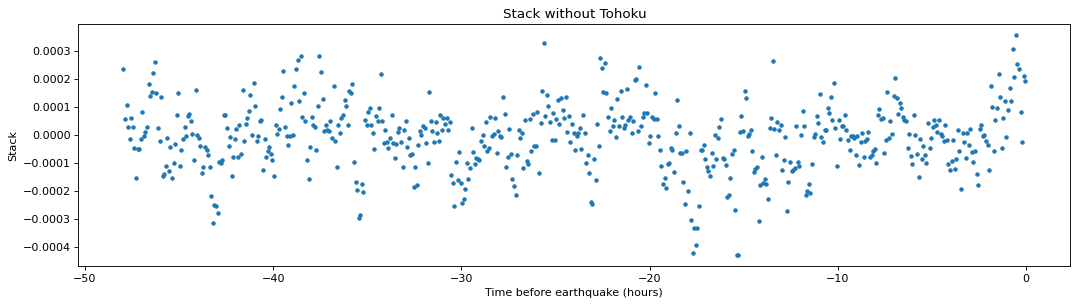

In [17]:
# Plot stack without Tohoku (Figure S3)

stack_no_TO = stack - eq_stack[I_TO]

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack_no_TO,'.')
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Stack')
plt.title('Stack without Tohoku')
plt.savefig(fig_dir+'/Figure_S3.pdf')

In [18]:
# Caluclate earthquake weights in the global stack 

w = 24
ric, ri2hc, risgc = 0, 0, 0

for i in range(len(eq_stack)):
    ri0 = np.linalg.norm(stack)**2 - np.linalg.norm(stack-eq_stack[i])**2 
    ri = np.sign(ri0)*np.sqrt(abs(ri0))
    ri2h0 = np.linalg.norm(stack[-w-1:-1])**2 - np.linalg.norm(stack[-w-1:-1]-eq_stack[i][-w-1:-1])**2
    ri2h = np.sign(ri2h0)*np.sqrt(abs(ri2h0))
    ric = ric + ri
    ri2hc = ri2hc + ri2h
    risg = 100*sg1[i]/sum(sg1)

risum, ri2hsum = ric, ri2hc
ric, ri2hc = 0, 0
RI, RI2h = [], []

for i in range(len(eq_stack)):
    ri0 = np.linalg.norm(stack)**2 - np.linalg.norm(stack-eq_stack[i])**2 
    ri = np.sign(ri0)*np.sqrt(abs(ri0))/risum
    RI.append(float(ri))
    ri2h0 = np.linalg.norm(stack[-w-1:-1])**2 - np.linalg.norm(stack[-w-1:-1]-eq_stack[i][-w-1:-1])**2
    ri2h = np.sign(ri2h0)*np.sqrt(abs(ri2h0))/ri2hsum
    RI2h.append(float(ri2h)) 

RI = 100*np.array(RI)/sum(RI)
RI2h = 100*np.array(RI2h)/sum(RI2h)
sg1 = 100*np.array(sg1)/sum(sg1)

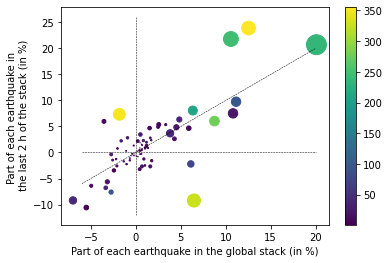

In [19]:
# Plot the earthquake weights (Figure S4)

plt.plot([-6,20],[-6,20],'k--',linewidth=0.5)
plt.plot([-6,20],[0,0],'k--',linewidth=0.5)
plt.plot([0,0],[-12,26],'k--',linewidth=0.5)
plt.scatter(RI,RI2h,s=20*sg1,c=np.array(Nst))
plt.colorbar()
plt.xlabel('Part of each earthquake in the global stack (in %)')
plt.ylabel('Part of each earthquake in \n the last 2 h of the stack (in %)')
plt.savefig(fig_dir+'/Figure_S4.pdf')

In [20]:
print('Coefficient of correlation between RI2h and RI: '+str(round(np.corrcoef(RI2h,RI)[0,1],2)))
print('Coefficient of correlation between RI2h and sigma: '+str(round(np.corrcoef(RI2h,sg1)[0,1],2)))
print('RI, RI2h, sigma and number of stations for earthquakes counting for more than 4% in the stack:')
for i in range(len(RI2h)):
    if sg1[i]>4:
        print(leq_file[i].split('/')[-2], round(RI[i],1), round(RI2h[i],1), round(sg1[i],1), Nst[i])
Irip = np.where(RI2h>0)[0]
Nstrip = 0
for i in range(len(Nst)):
    if RI2h[i]>0:
        Nstrip = Nstrip + Nst[i]
print('Number of earthquakes with postive contribution in the last 2 h: '+str(len(Irip))+' ('+str(round(100*len(Irip)/len(RI2h)))+'% of the total)') 
print('Number of stations that have recorded those earthquakes: '+str(Nstrip)+' ('+str(round(100*Nstrip/sum(Nst)))+'% of the total)')

Coefficient of correlation between RI2h and RI: 0.77
Coefficient of correlation between RI2h and sigma: 0.64
RI, RI2h, sigma and number of stations for earthquakes counting for more than 4% in the stack:
20110407T14:32:43_MW_7.1 -1.8 7.3 6.9 350
20140310T05:18:13_MW_7.0 10.6 21.8 11.1 246
20121207T08:18:23_MW_7.2 8.7 6.0 4.6 277
20110311T05:46:24_MW_9.0 12.5 23.9 9.4 355
20131025T17:10:19_MW_7.1 6.3 8.1 4.0 210
20100404T22:40:43_MW_7.1 20.1 20.7 19.8 236
20120905T14:42:07_MW_7.5 10.8 7.5 4.4 22
20110309T02:45:20_MW_7.3 6.5 -9.2 8.6 327
20161113T11:02:56_MW_7.9 11.2 9.8 4.4 97
Number of earthquakes with postive contribution in the last 2 h: 52 (58% of the total)
Number of stations that have recorded those earthquakes: 2235 (74% of the total)


Text(0.5, 1.0, 'Stacks of the earthquakes with 30 stations or more')

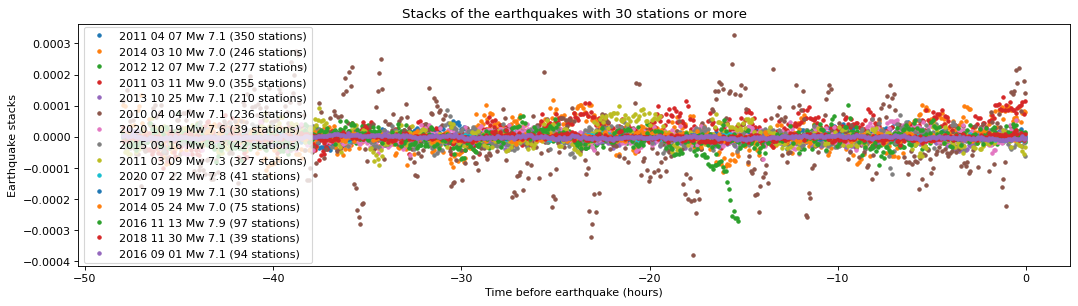

In [21]:
# Plot the stacks for the earthquakes with more than Nst_threshold stations

Nst_threshold = 30 # change this threshold to plot only earthquakes with Nst_threshold stations or more
ic, leg = 0, []

plt.figure(figsize=(16, 4), dpi=80)
for i in range(len(eq_stack)):
    if Nst[i]>=Nst_threshold:
        plt.plot(t,eq_stack[i],'.')
        #plt.scatter(t,eq_stack[i],s=0.7) # this makes smaller dots (useful if you plot more earthquakes)
        eq = str(leq_file[i].split('/')[-2])
        leg.append(eq[0:4]+' '+eq[4:6]+' '+eq[6:8]+' Mw '+eq[-3:len(eq)]+' ('+str(Nst[i])+' stations)')
        ic = ic + 1
plt.legend(leg,loc=6)
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Earthquake stacks')
plt.title('Stacks of the earthquakes with '+str(Nst_threshold)+' stations or more')

Text(0.5, 1.0, 'Stacks of the earthquakes counting for more than 4% in the stack')

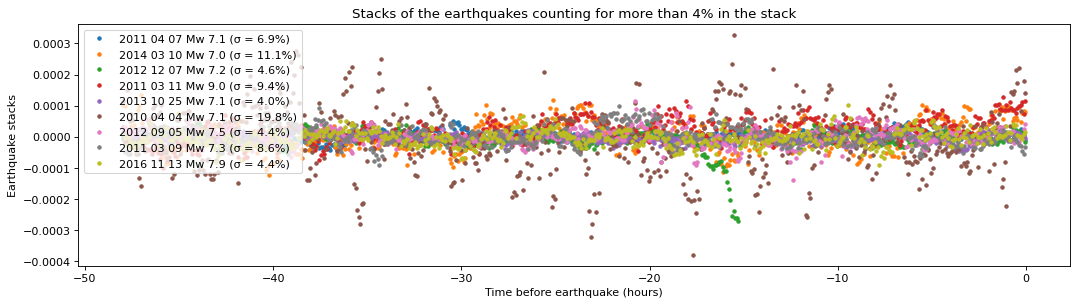

In [22]:
# Plot the stacks for the earthquakes with sigma > sg_threshold 

sg_threshold = 4 # change this threshold to plot only earthquakes with sigma > sg_threshold
ic, leg = 0, []

plt.figure(figsize=(16, 4), dpi=80)
for i in range(len(eq_stack)):
    if sg1[i]>sg_threshold:
        plt.plot(t,eq_stack[i],'.')
        eq = str(leq_file[i].split('/')[-2])
        leg.append(eq[0:4]+' '+eq[4:6]+' '+eq[6:8]+' Mw '+eq[-3:len(eq)]+' (\u03C3 = '+str(round(sg1[i],1))+'%)')
        ic = ic + 1
plt.legend(leg,loc=2)
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Earthquake stacks')
plt.title('Stacks of the earthquakes counting for more than '+str(sg_threshold)+'% in the stack')

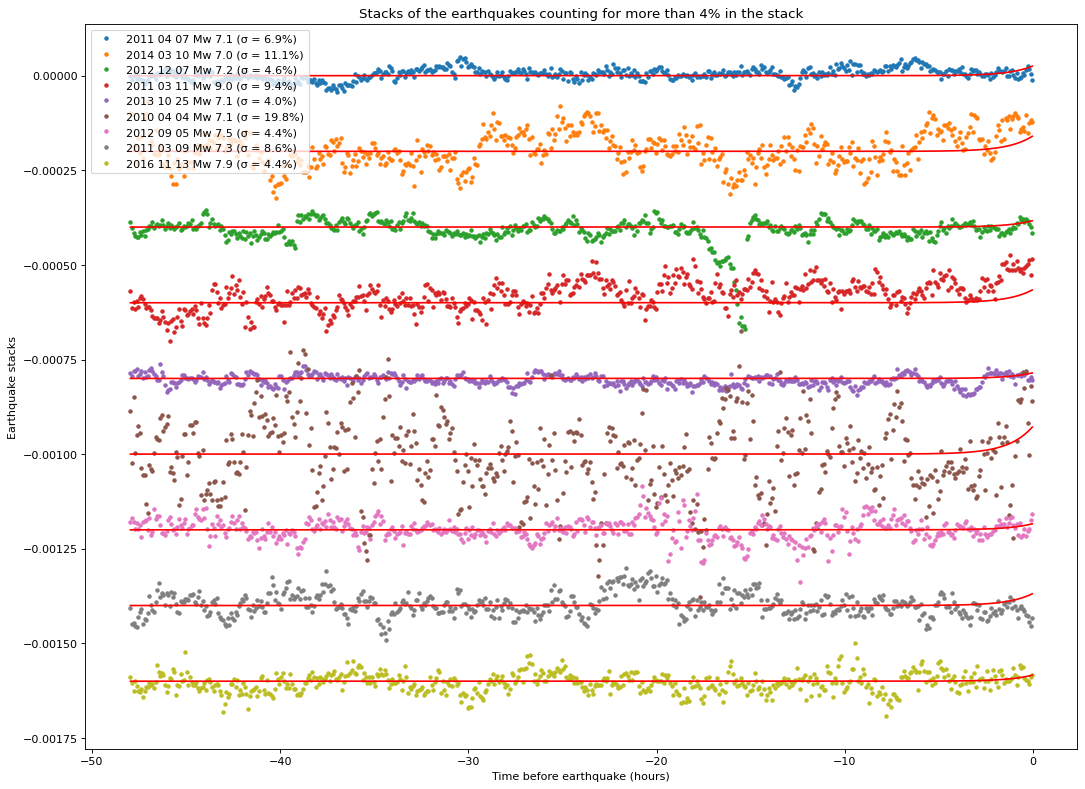

In [23]:
# Plot the stacks for the earthquakes with sigma > sg_threshold (Figure S5)

plt.figure(figsize=(16, 12), dpi=80)
ic, leg = 0, []
for i in range(len(eq_stack)):
    if sg1[i]>sg_threshold:
        plt.plot(t,eq_stack[i]-0.0002*ic,'.')
        eq = str(leq_file[i].split('/')[-2])
        leg.append(eq[0:4]+' '+eq[4:6]+' '+eq[6:8]+' Mw '+eq[-3:len(eq)]+' (\u03C3 = '+str(round(sg1[i],1))+'%)')
        ic = ic + 1
plt.legend(leg,loc=2)
ic = 0
for i in range(len(eq_stack)):
    if sg1[i]>sg_threshold:
        plt.plot(t,yexp*sg1[i]/100-0.0002*ic,'r')
        ic = ic + 1
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Earthquake stacks')
plt.title('Stacks of the earthquakes counting for more than '+str(sg_threshold)+'% in the stack')
plt.savefig(fig_dir+'/Figure_S5.pdf')

54 earthquake stacks have a positive mean in the last 2h (60% of the total), but they are made of 2251 time series (74% of the total)
List of the ones with more than 30 stations below:
  2011 04 07 Mw 7.1,  350 stations
  2014 03 10 Mw 7.0,  246 stations
  2012 12 07 Mw 7.2,  277 stations
  2011 03 11 Mw 9.0,  355 stations
  2013 10 25 Mw 7.1,  210 stations
  2010 04 04 Mw 7.1,  236 stations
  2017 09 19 Mw 7.1,  30 stations
  2016 11 13 Mw 7.9,  97 stations
  2018 11 30 Mw 7.1,  39 stations


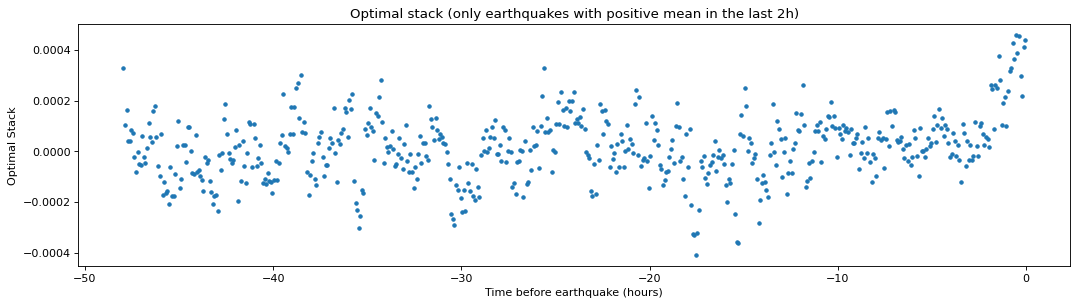

In [24]:
# Find which earthquake has positive mean in the last 2h, list them and plot their stack (optimal stack)

wd = 24
r = [0]*len(eq_stack)
for i in range(len(eq_stack)):
    r[i] = np.mean(eq_stack[i][-wd-1:-1])

rp = np.where(100*np.array(r)/sum(r)>0)
optimal_stack = stack * 0
NST = 0
for i in rp[0]:
    optimal_stack = optimal_stack + eq_stack[i]
    NST = NST + Nst[i]
    
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,optimal_stack,'.')
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Optimal Stack')
plt.title('Optimal stack (only earthquakes with positive mean in the last 2h)')

print(str(len(rp[0]))+' earthquake stacks have a positive mean in the last 2h ('+str(round(100*len(rp[0])/len(eq_stack)))+'% of the total), but they are made of '+str(NST)+' time series ('+str(round(100*NST/sum(Nst)))+'% of the total)')
print('List of the ones with more than 30 stations below:')

for i in rp[0]:  
    if Nst[i]>=30:
        eq = str(leq_file[i].split('/')[-2])
        print('  '+eq[0:4]+' '+eq[4:6]+' '+eq[6:8]+' Mw '+eq[-3:len(eq)]+',  '+str(Nst[i])+' stations')

36 earthquake stacks have a positive mean in the last 2h (40% of the total), but they are made of 775 time series (26% of the total)
List of the ones with more than 30 stations below:
  2020 10 19 Mw 7.6,  39 stations
  2015 09 16 Mw 8.3,  42 stations
  2011 03 09 Mw 7.3,  327 stations
  2020 07 22 Mw 7.8,  41 stations
  2014 05 24 Mw 7.0,  75 stations
  2016 09 01 Mw 7.1,  94 stations


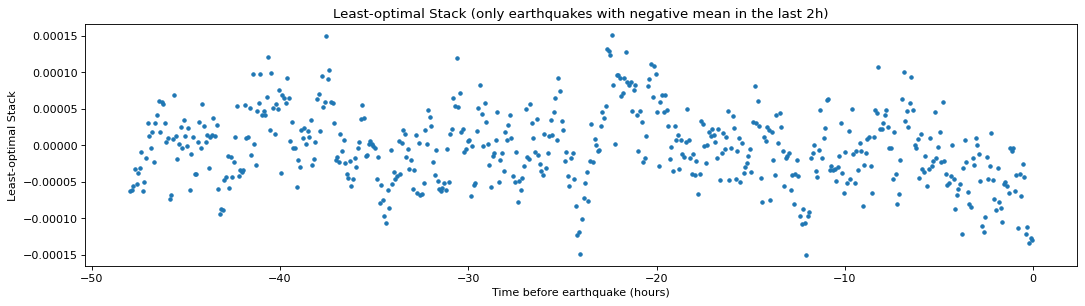

In [25]:
# Find which earthquake has negative mean in the last 2h, list them and plot their stack (least-optimal stack)

rn = np.where(np.array(r)<=0)
leftover_stack = stack * 0
NSTn = 0
for i in rn[0]:
    leftover_stack = leftover_stack + eq_stack[i]
    NSTn = NSTn + Nst[i]

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,leftover_stack,'.')
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Least-optimal Stack')
plt.title('Least-optimal Stack (only earthquakes with negative mean in the last 2h)')

print(str(len(rn[0]))+' earthquake stacks have a positive mean in the last 2h ('+str(round(100*len(rn[0])/len(eq_stack)))+'% of the total), but they are made of '+str(NSTn)+' time series ('+str(round(100*NSTn/sum(Nst)))+'% of the total)')
print('List of the ones with more than 30 stations below:')

for i in rn[0]: 
    if Nst[i]>=30:
        eq = str(leq_file[i].split('/')[-2])
        print('  '+eq[0:4]+' '+eq[4:6]+' '+eq[6:8]+' Mw '+eq[-3:len(eq)]+',  '+str(Nst[i])+' stations')

In [26]:
# Make global stacks with stations within 100, 200, 300 and 400 km radius

from pyacs.lib.coordinates import geo_spherical_distance
from datetime import datetime

B = np.genfromtxt('scardec_M7_full.txt')
eq_lat, eq_lon, eq_date = B[:,7], B[:,8], []
for i in range(len(B)):
    eq_date.append(datetime(int(B[i,1]),int(B[i,2]),int(B[i,3]),int(B[i,4]),int(B[i,5])))
eq_stack_100, eq_stack_200, eq_stack_300, eq_stack_400  = [], [], [], []

for eq_file in leq_file:
    eq = eq_file.split('/')[-2]
    I_eq = int(np.where(np.array(eq_date)==datetime(int(eq[0:4]),int(eq[4:6]),int(eq[6:8]),int(eq[9:11]),int(eq[12:14])))[0])
    code = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=str,usecols=0))
    st_lon = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=1))
    st_lat = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=2))
    syn_east = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=0))
    syn_north = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=1))
    sigmaj2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmaj2.txt'))
    for i in range(len(st_lon)):
        st_dist = geo_spherical_distance(st_lon[i],st_lat[i],0,eq_lon[I_eq],eq_lat[I_eq],0,unit='dec_deg')/1000
        ts = np.genfromtxt(data_byEQ_dir+'/'+eq+'/TS_'+code[i]+'.dat')
        east, north = ts[:,7], ts[:,8]
        east0, north0 = np.median(east[0:nd]), np.median(north[0:nd])
        dot_product = ( (east-east0)*syn_east[i] + (north-north0)*syn_north[i] ) / sigmaj2[i]
        if st_dist<400:
            eq_stack_400.append(dot_product)
        if st_dist<300:
            eq_stack_300.append(dot_product)
        if st_dist<200:
            eq_stack_200.append(dot_product) 
        if st_dist<100:
            eq_stack_100.append(dot_product)

stack_100, stack_200, stack_300, stack_400 = sum(eq_stack_100), sum(eq_stack_200), sum(eq_stack_300), sum(eq_stack_400)

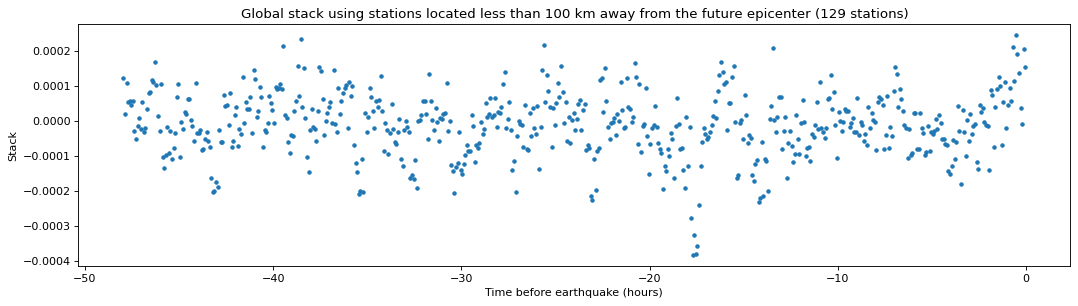

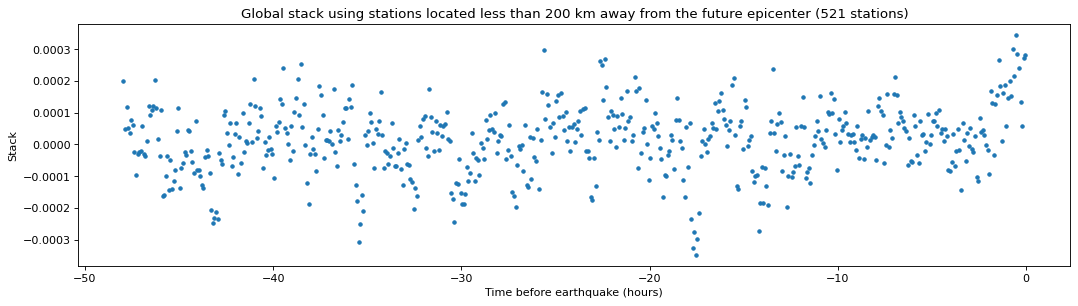

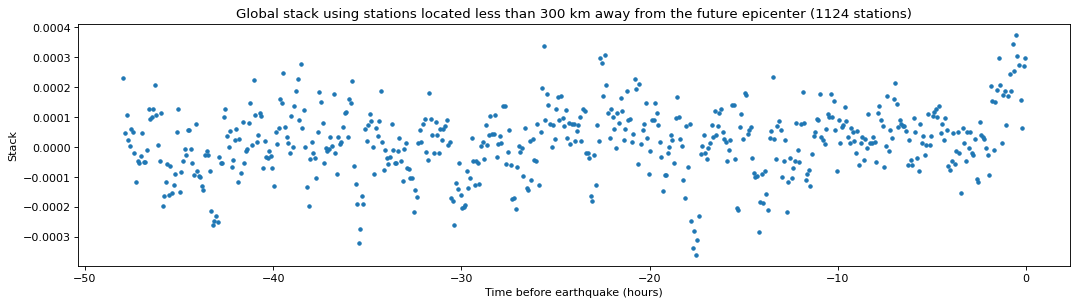

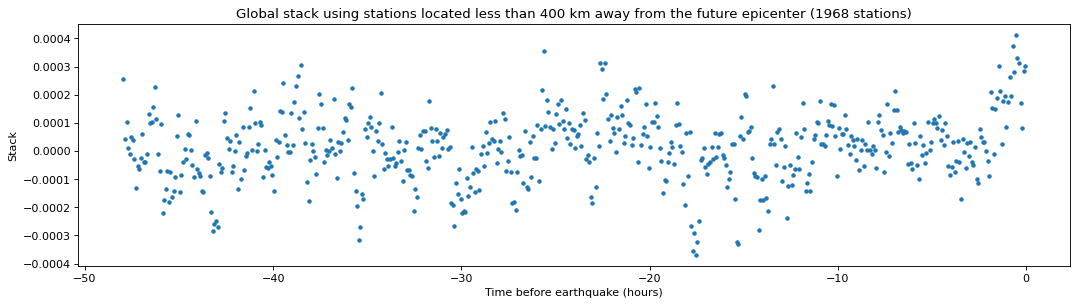

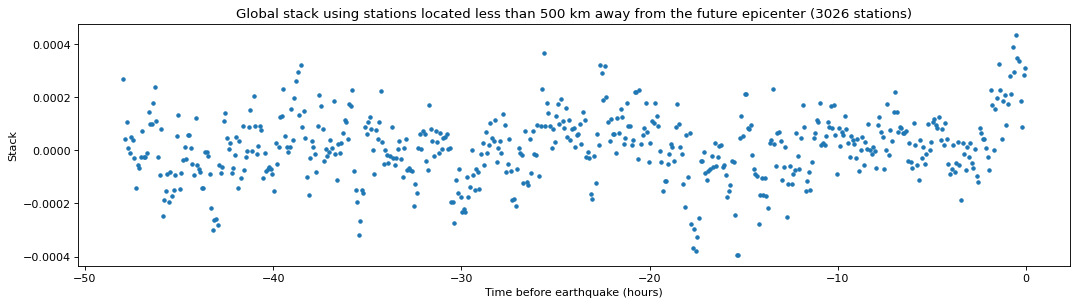

In [27]:
# Plot global stacks with stations within 100, 200, 300, 400 and 500 km radius (Figure S8)

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack_100,'.')
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Stack')
plt.title('Global stack using stations located less than 100 km away from the future epicenter ('+str(len(eq_stack_100))+' stations)')
plt.savefig(fig_dir+'/Figure_S8a.pdf')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack_200,'.')
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Stack')
plt.title('Global stack using stations located less than 200 km away from the future epicenter ('+str(len(eq_stack_200))+' stations)')
plt.savefig(fig_dir+'/Figure_S8b.pdf')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack_300,'.')
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Stack')
plt.title('Global stack using stations located less than 300 km away from the future epicenter ('+str(len(eq_stack_300))+' stations)')
plt.savefig(fig_dir+'/Figure_S8c.pdf')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack_400,'.')
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Stack')
plt.title('Global stack using stations located less than 400 km away from the future epicenter ('+str(len(eq_stack_400))+' stations)')
plt.savefig(fig_dir+'/Figure_S8d.pdf')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack,'.')
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Stack')
plt.title('Global stack using stations located less than 500 km away from the future epicenter ('+str(sum(Nst))+' stations)')
plt.savefig(fig_dir+'/Figure_S8e.pdf')

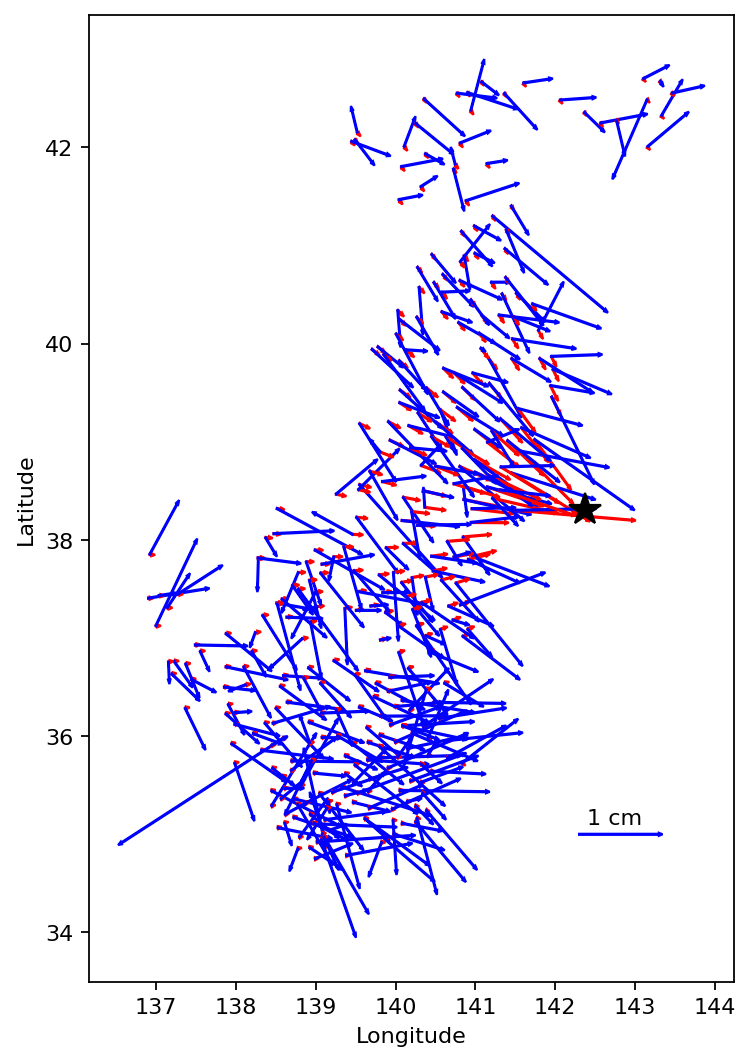

In [28]:
# Plot map view of the signal in the last 2 hours for Tohoku (Figure S6A)

Im = I_TO # Change I_TO to any number to plot the map view of another earthquake
w = 24 # window duration to make linear regression (in samples)
a, b = 1E5, 1E2 # ad-hoc scaling factors for plotting

eq = leq_file[Im].split('/')[-2]
I_eq = int(np.where(np.array(eq_date)==datetime(int(eq[0:4]),int(eq[4:6]),int(eq[6:8]),int(eq[9:11]),int(eq[12:14])))[0])

np_code = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq_dir[Im]+'/station_list.txt',dtype=str,usecols=0))
st_lon = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq_dir[Im]+'/station_list.txt',dtype=float,usecols=1))
st_lat = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq_dir[Im]+'/station_list.txt',dtype=float,usecols=2))
syn_east = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq_dir[Im]+'/synthetics.txt',dtype=float,usecols=0))
syn_north = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq_dir[Im]+'/synthetics.txt',dtype=float,usecols=1))
sigmaj2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq_dir[Im]+'/sigmaj2.txt'))

obs_east, obs_north, i = [], [], 0
for code in np_code:
    ts = np.genfromtxt(data_byEQ_dir+'/'+eq+'/TS_'+code+'.dat')
    obs_east.append((np.median(ts[-w-1:-1,7])-np.median(ts[0:nd,7])))
    obs_north.append((np.median(ts[-w-1:-1,8])-np.median(ts[0:nd,8])))
    i = i+1

h =(max(st_lon)-min(st_lon))*np.cos(38*np.pi/180)/(max(st_lat)-min(st_lat))
plt.figure(figsize=(8*h, 8), dpi=160)
plt.plot(eq_lon[I_eq],eq_lat[I_eq],'*k',markersize=15)
plt.arrow(142.3,35,10*b*1E-3,0,width = 0.01,color='blue')
plt.text(142.4,35.1,'1 cm')
for i in range(len(st_lon)):
    plt.arrow(st_lon[i],st_lat[i],syn_east[i]*a,syn_north[i]*a,width = 0.01,color='red')
    plt.arrow(st_lon[i],st_lat[i],obs_east[i]*b,obs_north[i]*b,width = 0.01,color='blue')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig(fig_dir+'/Figure_S6a.pdf')

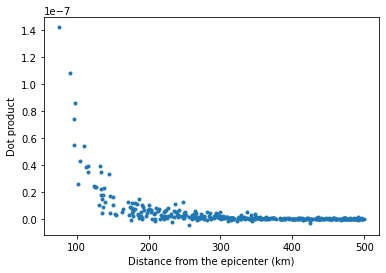

In [29]:
# Plot dot product by station as a function distance from Tohoku epicenter (Figure S6B)

dist_TO = []
for i in range(len(st_lon)):
    dist_TO.append(geo_spherical_distance(st_lon[i],st_lat[i],0,eq_lon[I_eq],eq_lat[I_eq],0,unit='dec_deg')/1000)
    
plt.plot(dist_TO,obs_east*syn_east+obs_north*syn_north,'.')
plt.xlabel('Distance from the epicenter (km)')
plt.ylabel('Dot product')
plt.savefig(fig_dir+'/Figure_S6b.pdf')

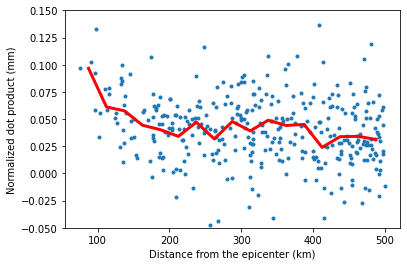

In [30]:
# Plot normalized dot product by station as a function distance from Tohoku epicenter (Figure S6C)

g_norm = np.sqrt(syn_east*syn_east+syn_north*syn_north)
dp_norm = np.array((obs_east*syn_east+obs_north*syn_north)/g_norm)*10

dist, dp_ma = [], []
for d in range(75,500,25):
    II = np.where((np.array(dist_TO)>d) & (np.array(dist_TO)<=d+25))
    dist.append(d+12.5)
    dp_ma.append(np.mean(dp_norm[II]))

plt.plot(dist_TO,dp_norm,'.')
plt.plot(dist,dp_ma,'r',linewidth=3)
#plt.ylim([-3,7.8])
plt.ylim([-0.05,0.15])
plt.xlabel('Distance from the epicenter (km)')
plt.ylabel('Normalized dot product (mm)')
plt.savefig(fig_dir+'/Figure_S6c.pdf')

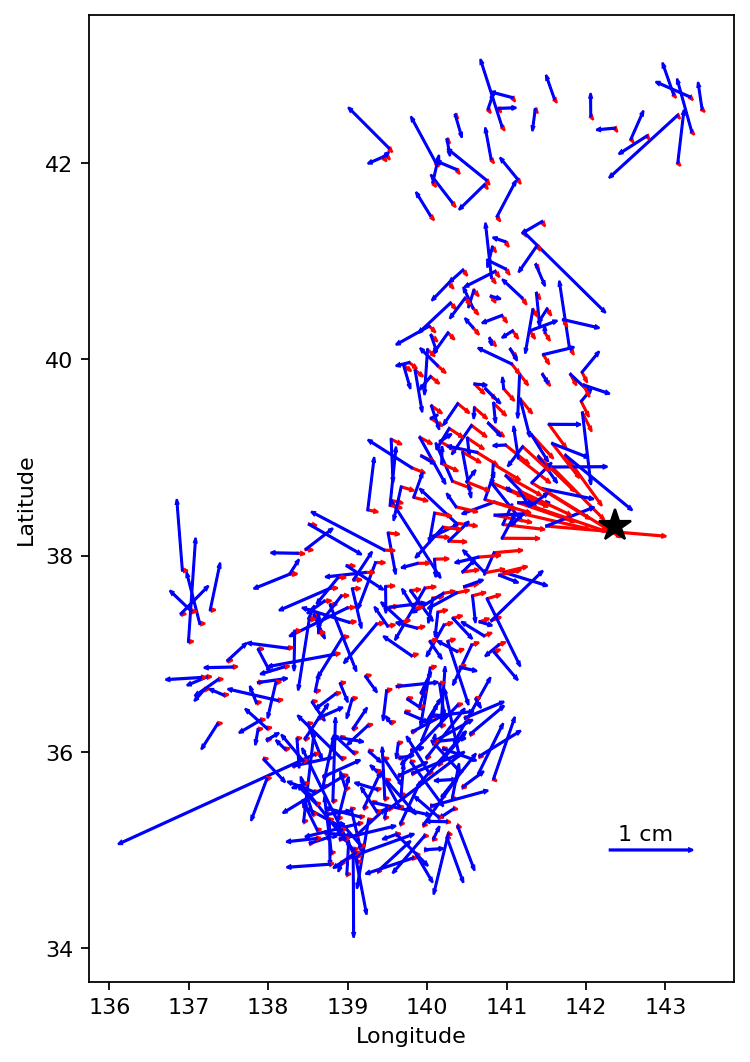

In [31]:
# Re-plot Figure S6A after removing the common mode (Figure S7A)

cmode_east, cmode_north = np.mean(obs_east), np.mean(obs_north)
obs_east_2 = obs_east - cmode_east
obs_north_2 = obs_north - cmode_north

plt.figure(figsize=(8*h, 8), dpi=160)
plt.plot(eq_lon[I_eq],eq_lat[I_eq],'*k',markersize=15)
plt.arrow(142.3,35,10*b*1E-3,0,width = 0.01,color='blue')
plt.text(142.4,35.1,'1 cm')
for i in range(len(st_lon)):
    plt.arrow(st_lon[i],st_lat[i],syn_east[i]*a,syn_north[i]*a,width = 0.01,color='red')
    plt.arrow(st_lon[i],st_lat[i],obs_east_2[i]*b,obs_north_2[i]*b,width = 0.01,color='blue')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig(fig_dir+'/Figure_S7a.pdf')

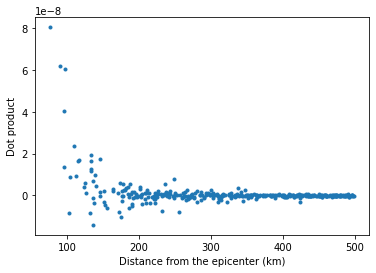

In [32]:
# Re-plot Figure S6B after removing the common mode (Figure S7B)

dist_TO = []
for i in range(len(st_lon)):
    dist_TO.append(geo_spherical_distance(st_lon[i],st_lat[i],0,eq_lon[I_eq],eq_lat[I_eq],0,unit='dec_deg')/1000)
    
plt.plot(dist_TO,obs_east_2*syn_east+obs_north_2*syn_north,'.')
plt.xlabel('Distance from the epicenter (km)')
plt.ylabel('Dot product')
plt.savefig(fig_dir+'/Figure_S7b.pdf')

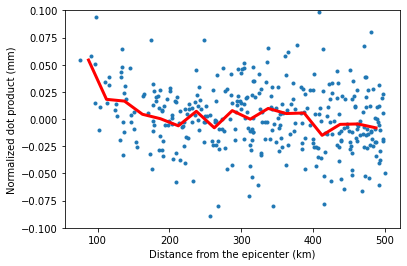

In [33]:
# Re-plot Figure S6C after removing the common mode (Figure S7C)

dp_norm_2 = np.array((obs_east_2*syn_east+obs_north_2*syn_north)/g_norm)*10

dp_ma_2 = []
for d in range(75,500,25):
    II = np.where((np.array(dist_TO)>d) & (np.array(dist_TO)<=d+25))
    dp_ma_2.append(np.mean(dp_norm_2[II]))

plt.plot(dist_TO,dp_norm_2,'.')
plt.plot(dist,dp_ma_2,'r',linewidth=3)
#plt.ylim([-5,6])
plt.ylim([-0.1,0.1])
plt.xlabel('Distance from the epicenter (km)')
plt.ylabel('Normalized dot product (mm)')
plt.savefig(fig_dir+'/Figure_S7c.pdf')

/var/folders/v1/kmfkhgc56g771mgzjb60mct40000gq/T/ipykernel_3094/4078563764.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16, 4), dpi=80)
/Users/quentin/anaconda3/envs/env_pyacs/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


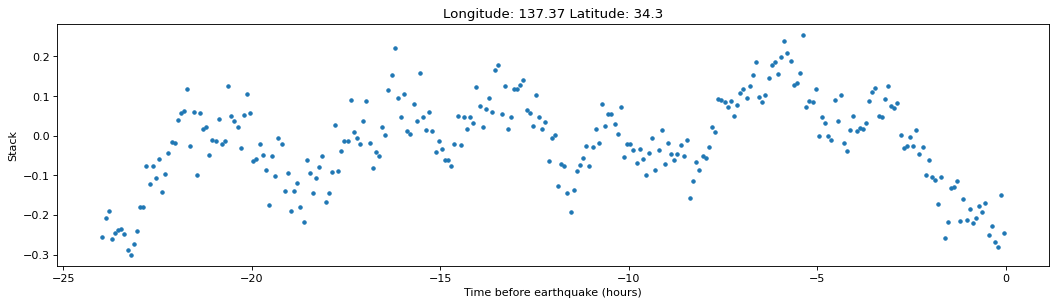

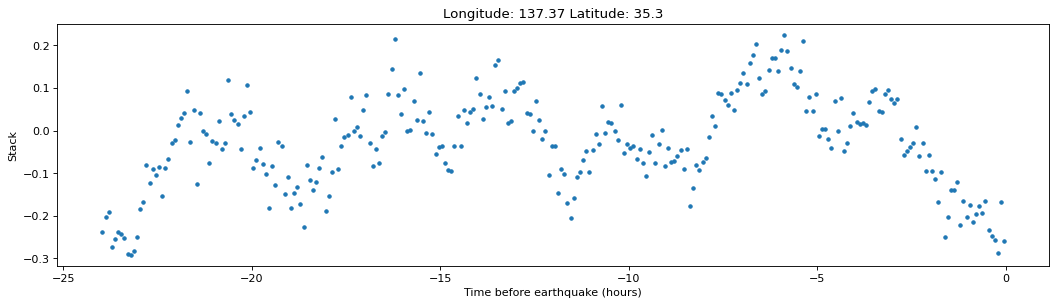

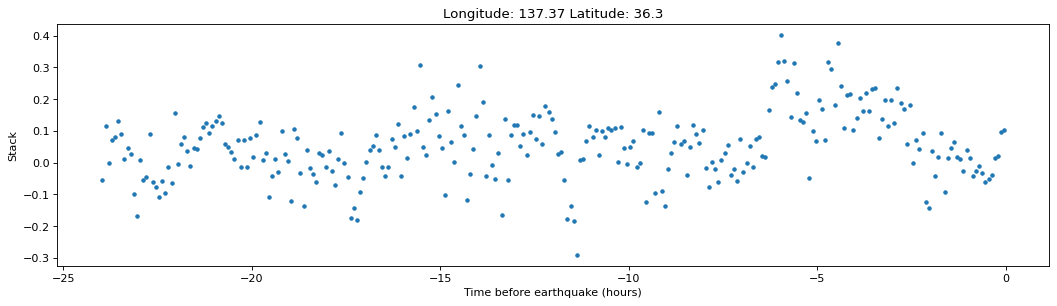

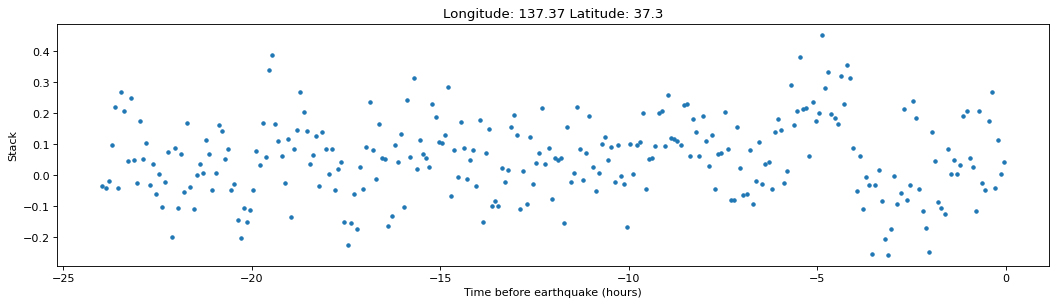

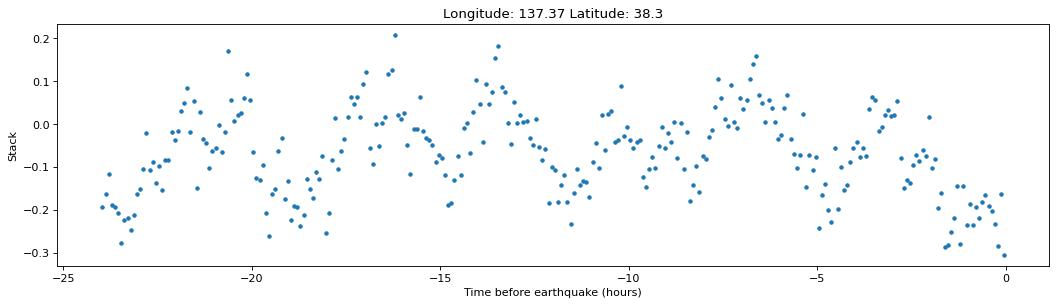

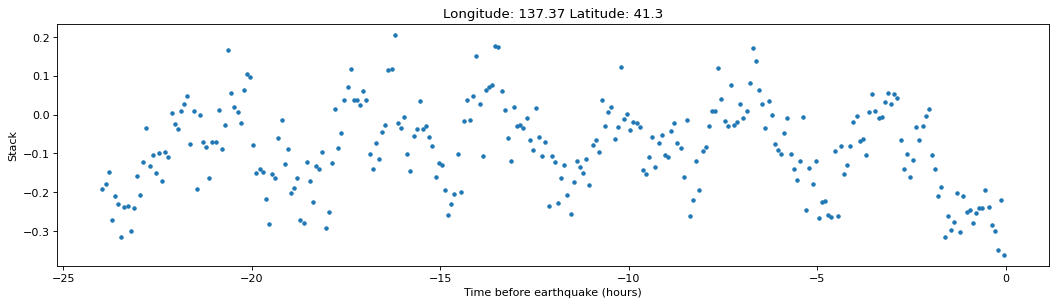

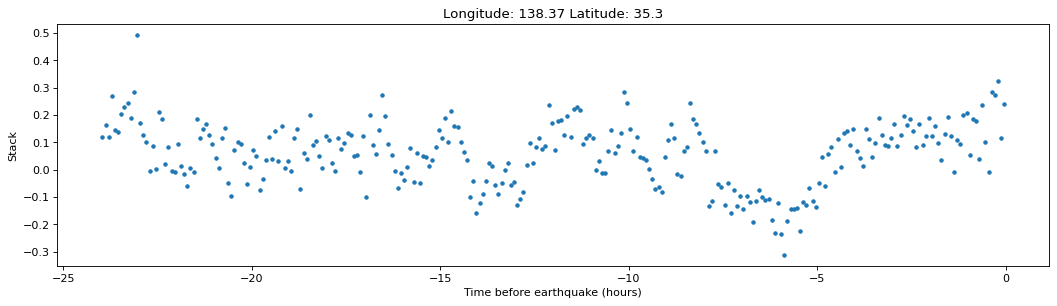

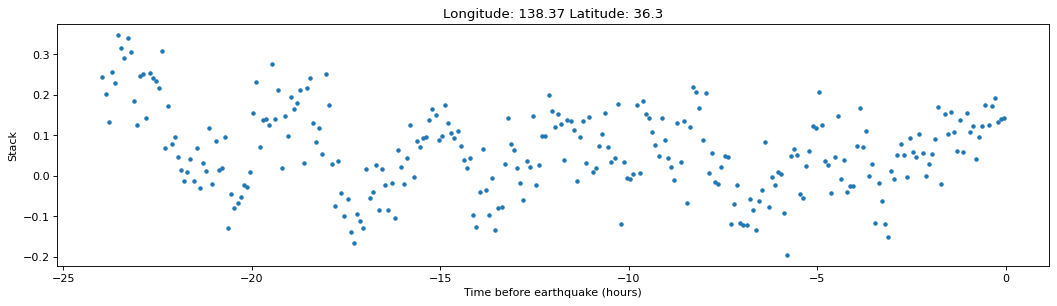

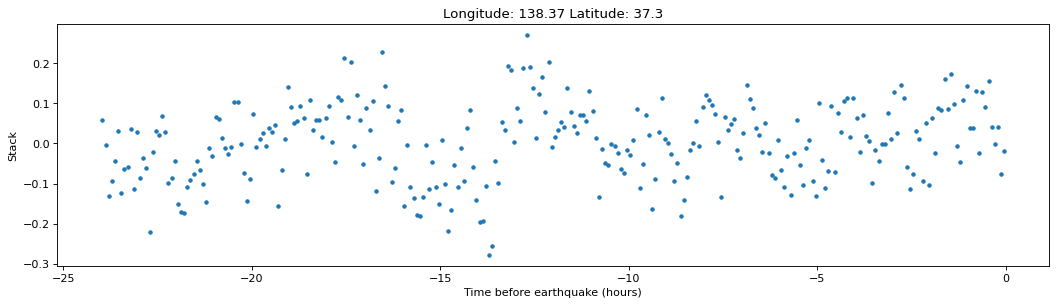

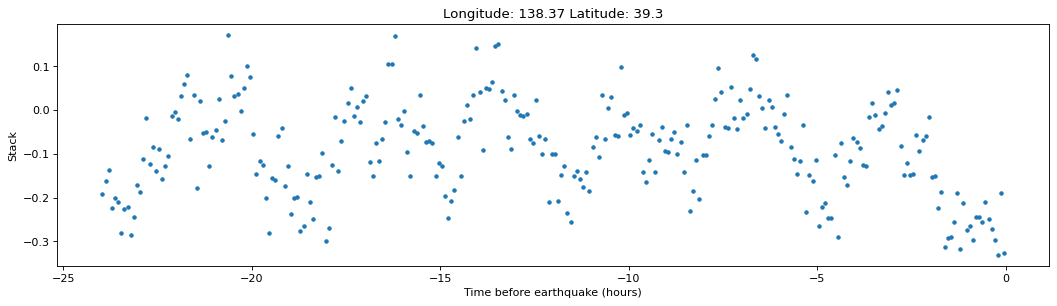

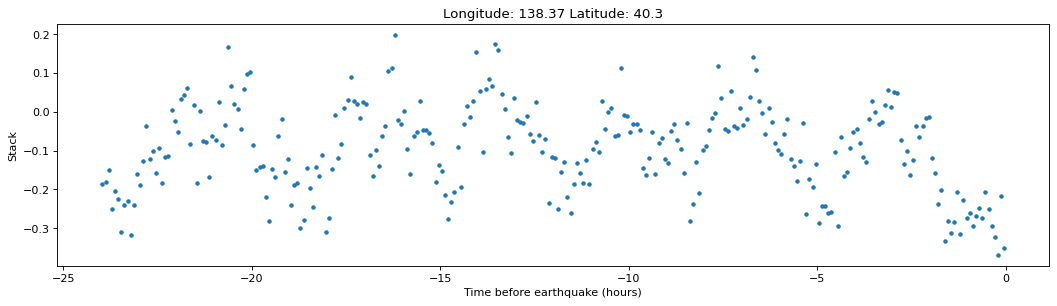

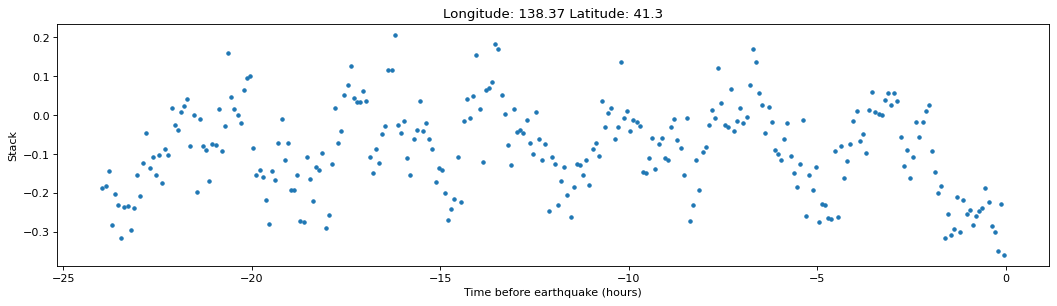

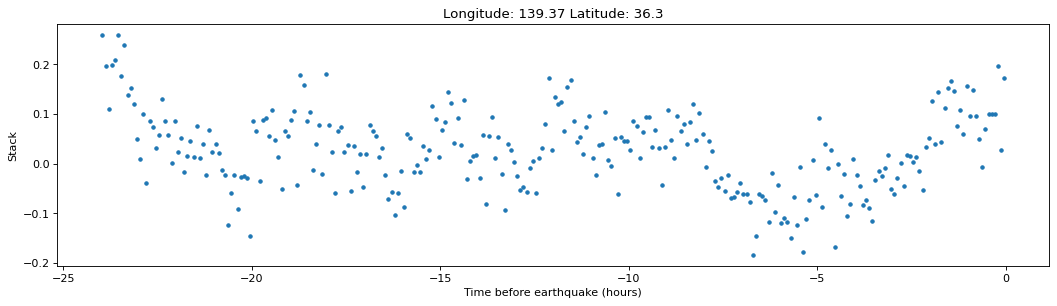

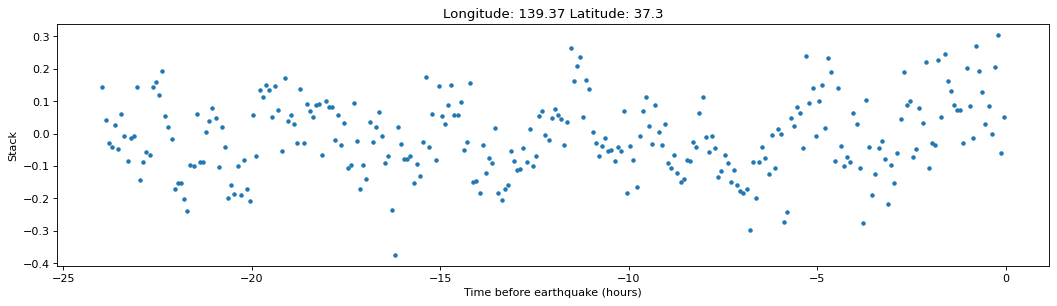

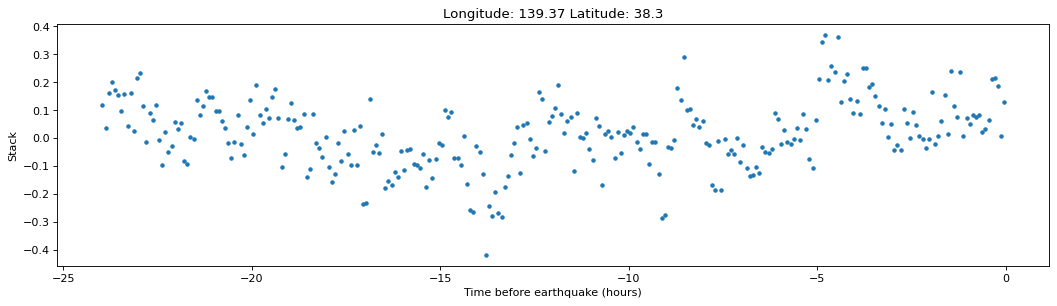

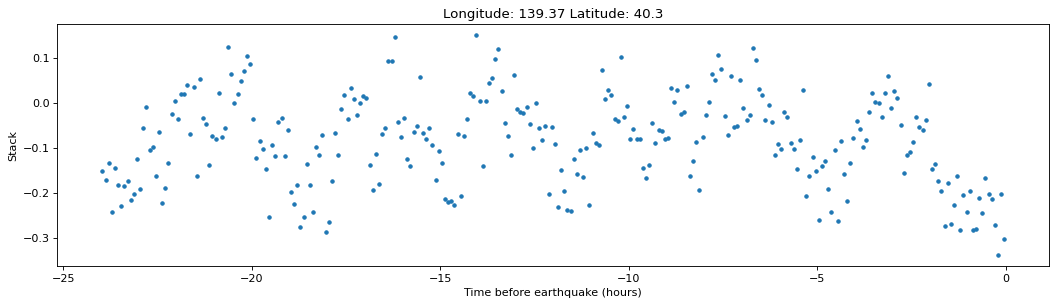

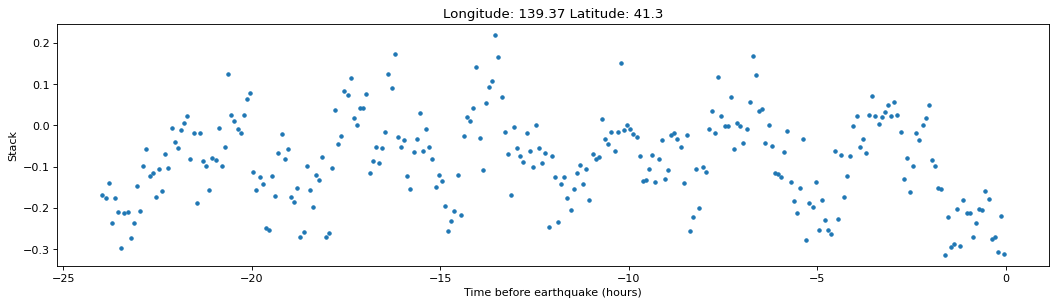

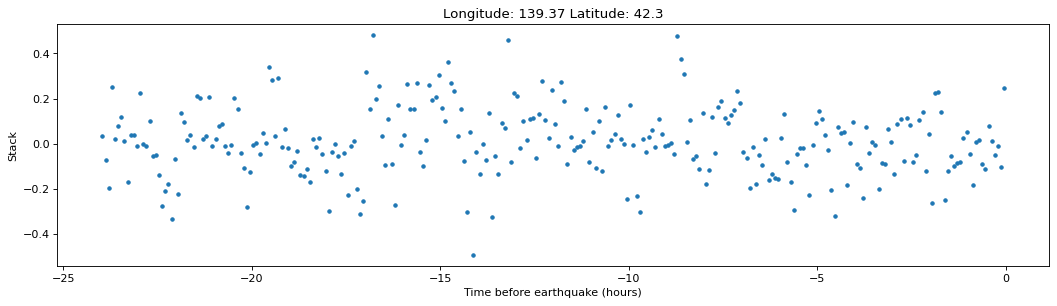

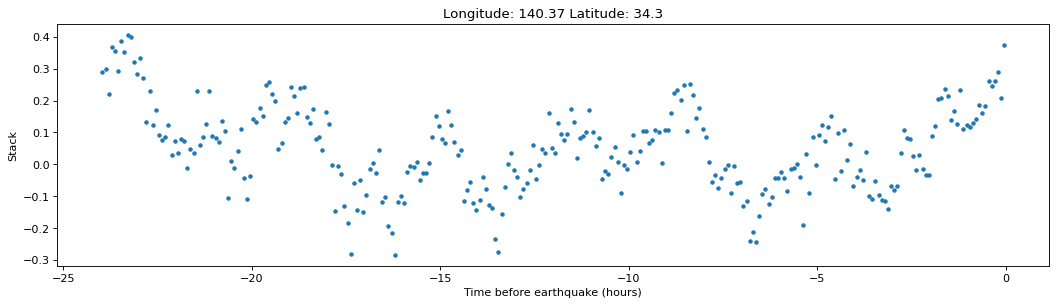

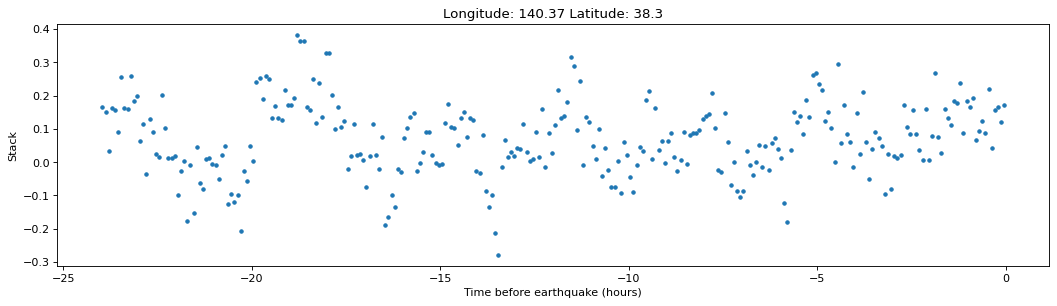

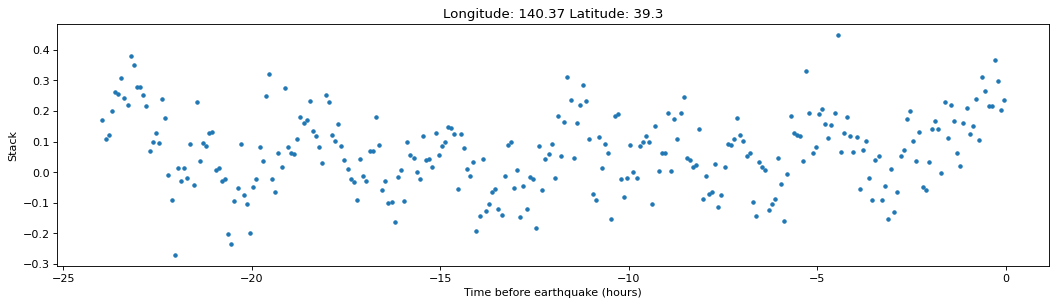

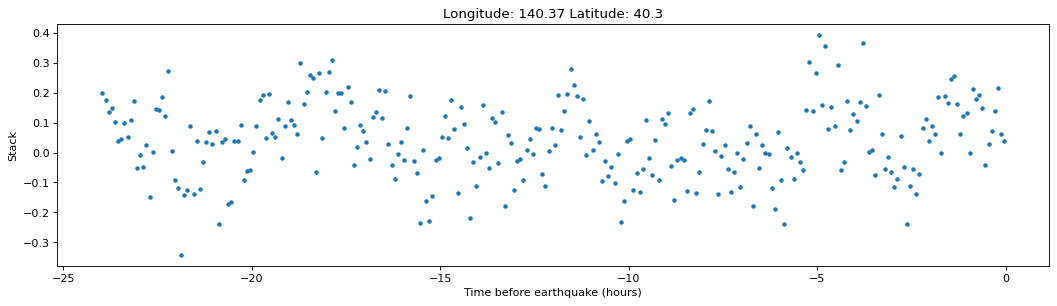

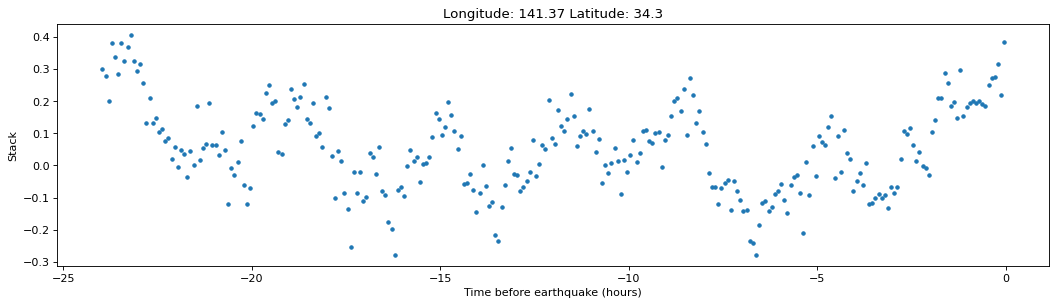

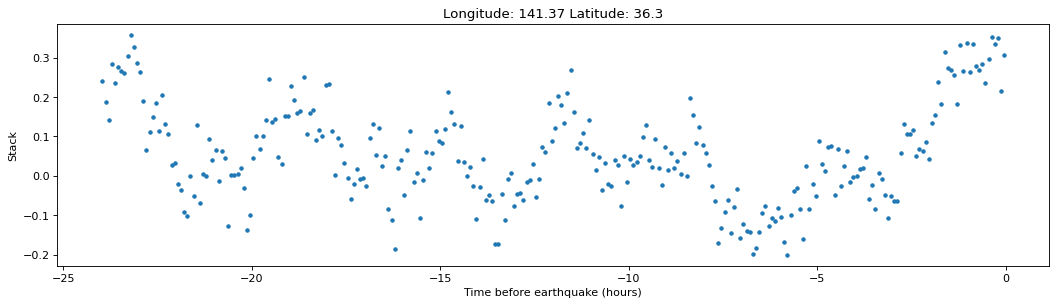

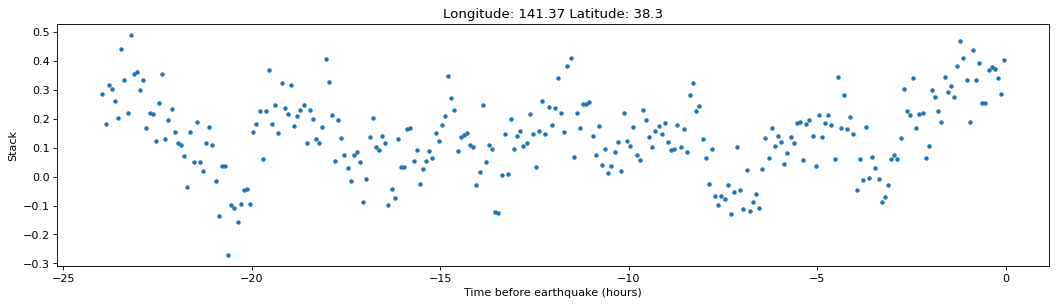

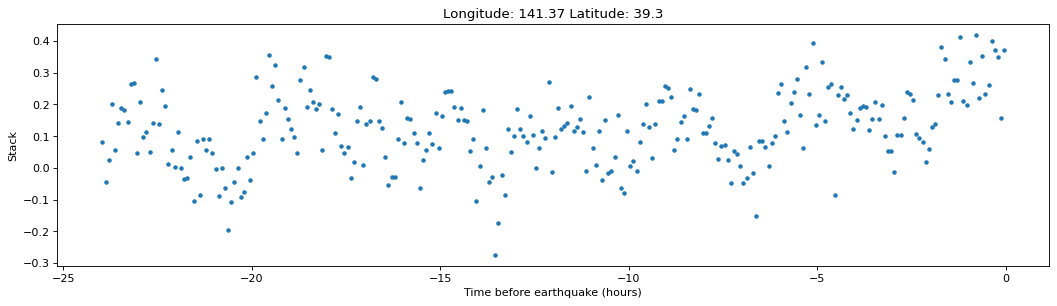

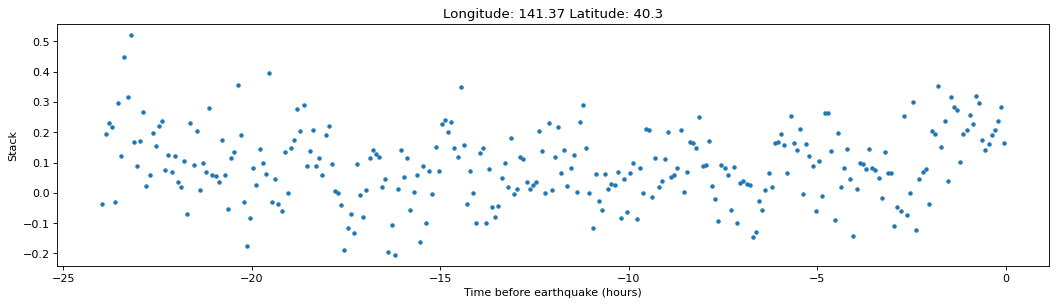

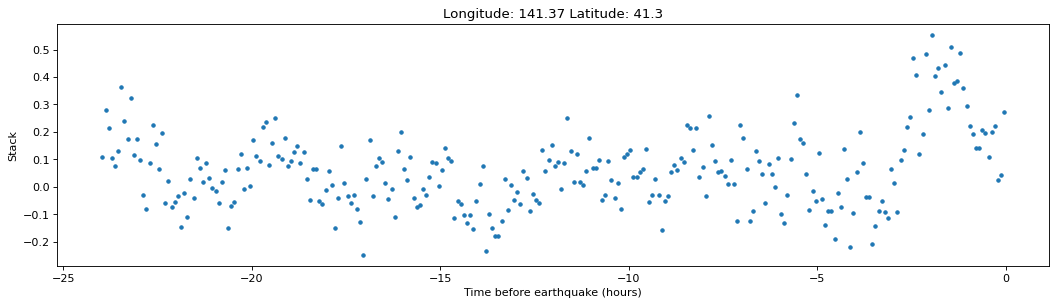

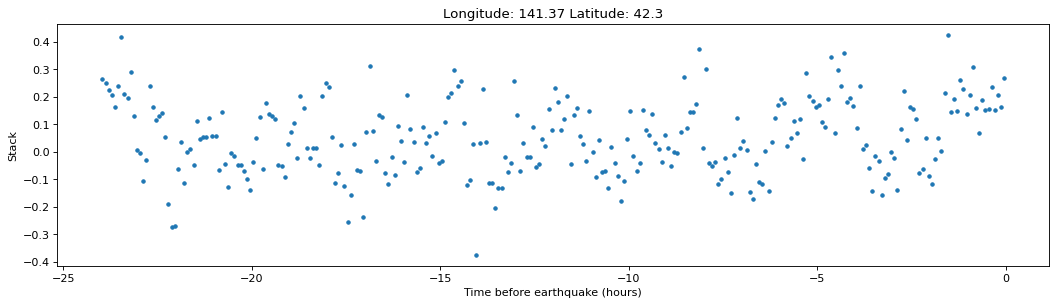

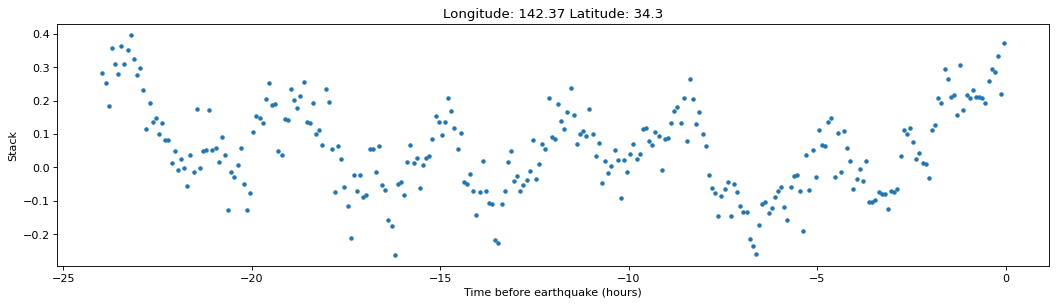

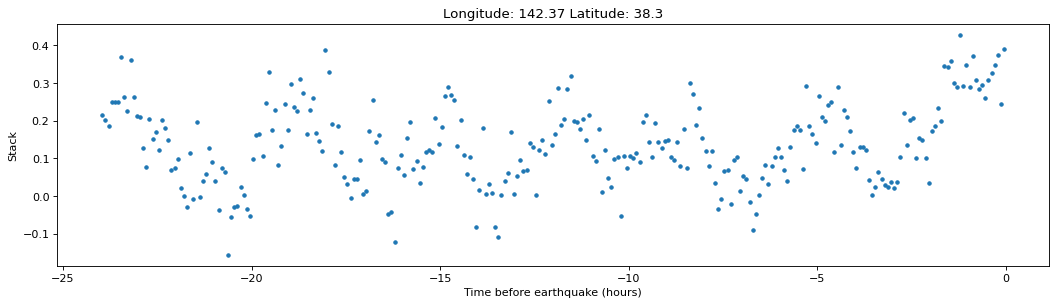

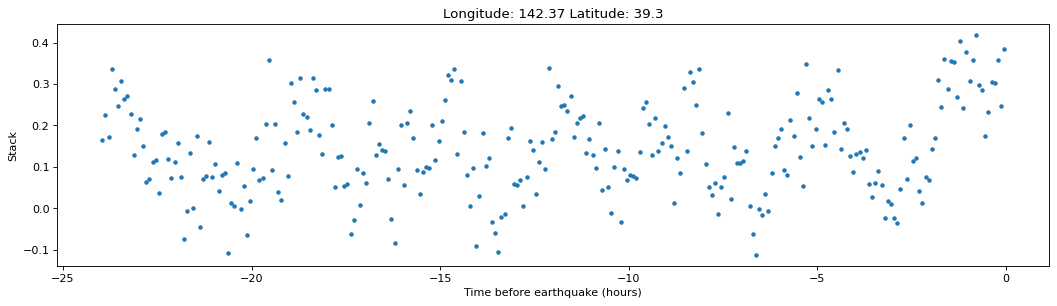

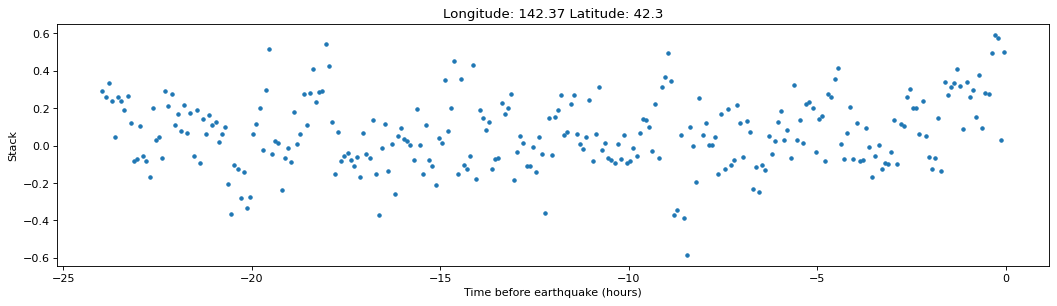

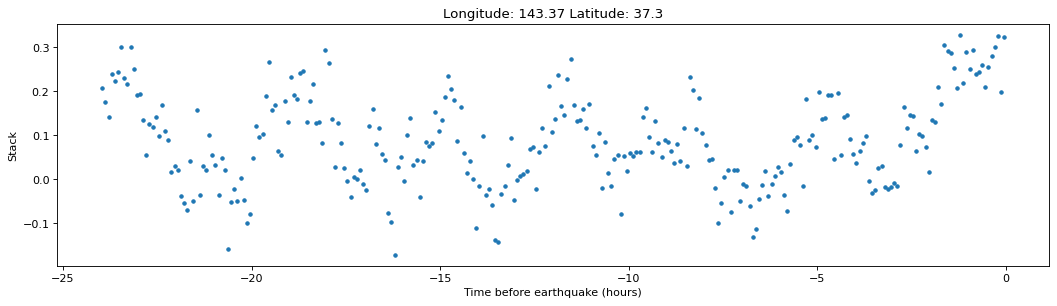

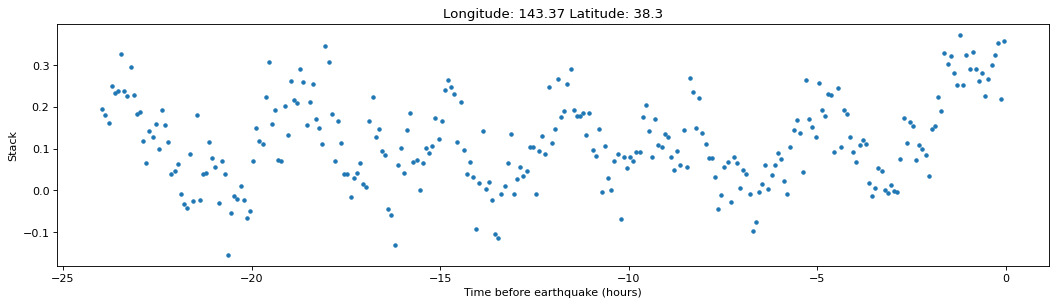

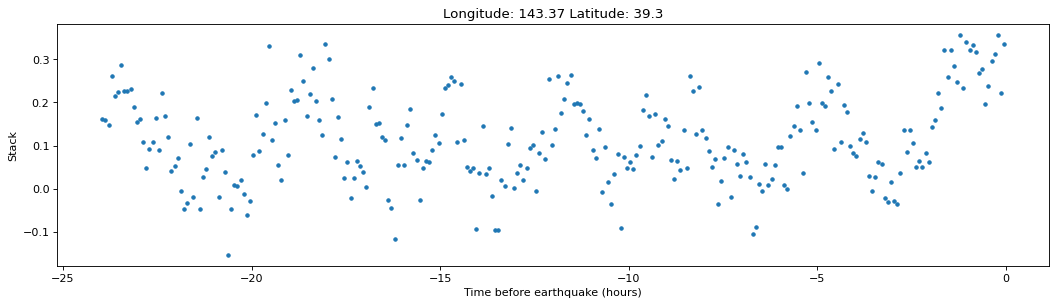

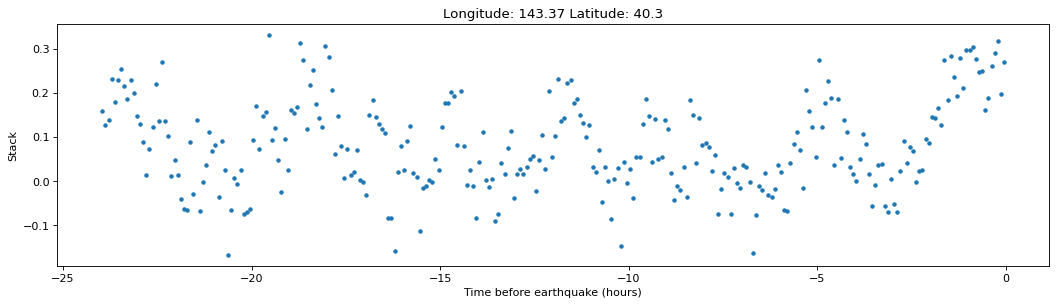

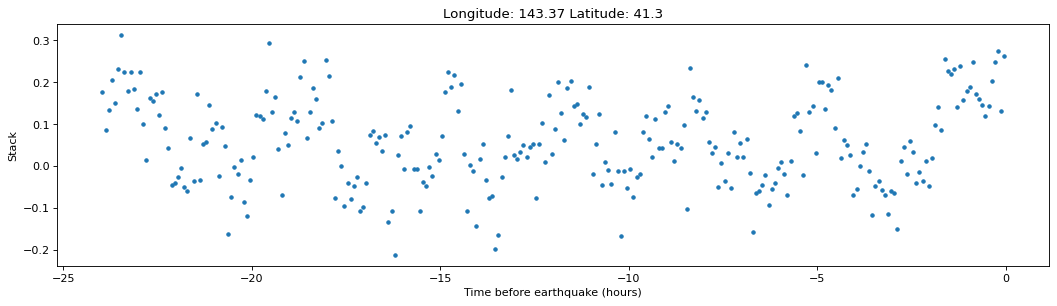

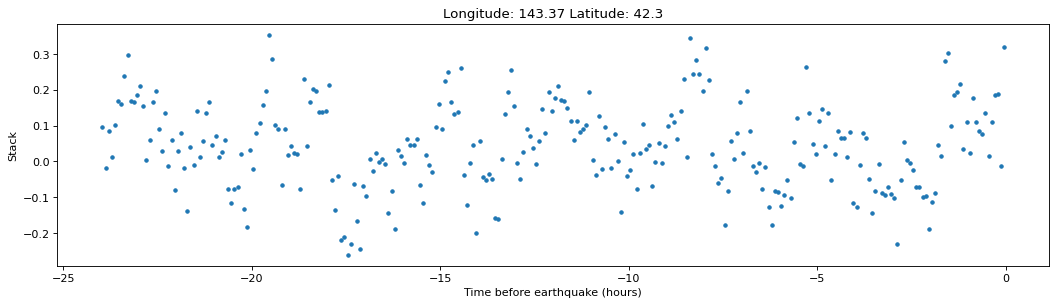

In [34]:
# Calculate Tohoku stack for different source locations 

lon, lat, dep, strike, dip, rake = 142.37, 38.3, 15, 197, 14, 84

array_gps = np.transpose(np.array([st_lon,st_lat]))
lon_dp, lat_dp = [], []
rmsred_dp, T_dp, dp_2h, = [], [], []

#xl, yl = 0, 0
#xl, yl = -3, 1
for xl in range(-5,2):
    for yl in range(-4,5):
        lon_dp.append(lon+xl)
        lat_dp.append(lat+yl)
        geometry = np.array([[lon+xl,lat+yl,dep,L,W,L*W,1,strike,dip,0,0,0,0,0,0,0,0,0,0,0,0,0]])
        green = pyeq.green.make.nikkhoo_rde(geometry,array_gps,coor_type='geo',tensile=False,disp=True,strain=False,stress=False,lam=28758000000.0,mu=29353000000.0,verbose=False)
        r_rake = np.radians(rake)
        green_east = np.cos(r_rake)*green[0,:,0,0] + np.sin(r_rake)*green[0,:,0,1]
        green_north = np.cos(r_rake)*green[0,:,1,0] + np.sin(r_rake)*green[0,:,1,1]
        
        i = 0
        dp, sg = np.zeros([len(np_code), nsample]), np.zeros([len(np_code), 1])
        for code in np_code:
            ts = np.genfromtxt(data_byEQ_dir+'/'+eq+'/TS_'+code+'.dat')
            east, north = ts[:,7], ts[:,8]
            east0, north0 = np.median(east[0:nd]), np.median(north[0:nd])
            dp[i,:] = ( (east-east0)*green_east[i] + (north-north0)*green_north[i] ) / sigmaj2[i]
            sg[i] = np.sqrt(green_east[i]*green_east[i] + green_north[i]*green_north[i])
            i = i+1

        dp_m = sum(dp)[nd:nsample]/sum(sg) 
        dp_2h.append(np.mean(dp_m[-24:-1]))
        try:
            res = fit_sin(t_TO,dp_m)
            dp_sin = res["fitfunc"](np.array(t_TO))   
            rmsred_dp.append(100*(np.linalg.norm(dp_m)**2-np.linalg.norm(dp_m-dp_sin)**2)/np.linalg.norm(dp_m)**2)
            T_dp.append(res['period'])
        except:
            rmsred_dp.append(0)
            T_dp.append(0)                                                 
                                                               
        plt.figure(figsize=(16, 4), dpi=80)
        plt.plot(t_TO,dp_m,'.')
        plt.xlabel('Time before earthquake (hours)')
        plt.ylabel('Stack')
        plt.title('Longitude: '+str(round(lon+xl,2))+' Latitude: '+str(round(lat+yl,2)))
        plt.savefig(TO_fig_dir+'/lon_'+str(xl)+'_lat_'+str(yl)+'.pdf')

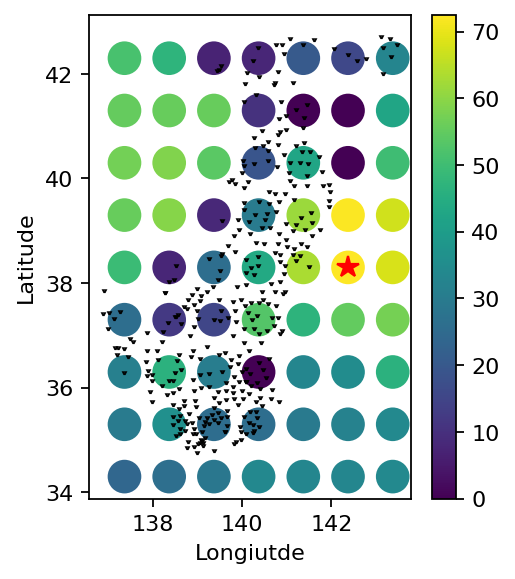

In [35]:
# Plot peridoicity (misfit reduction provided best sinusoidal fit) in % for different source locations (Figure S11A)

plt.figure(figsize=(4*h*1.25, 4), dpi=160)
plt.plot(st_lon,st_lat,'vk',markersize=1)
plt.plot(eq_lon[I_eq],eq_lat[I_eq],'*r',markersize=10)
plt.scatter(lon_dp,lat_dp,200,rmsred_dp)
plt.xlabel('Longiutde')
plt.ylabel('Latitude')
plt.colorbar()
plt.savefig(fig_dir+'/Figure_S11a.pdf')

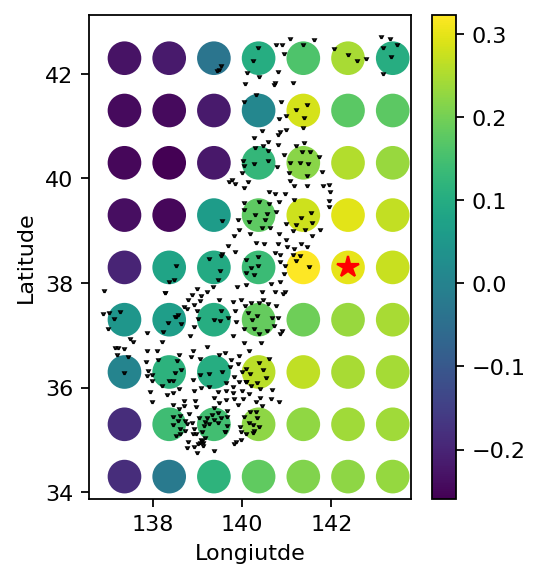

In [36]:
# Plot averaged values in the last 2 h for Tohoku stacks calculated considering different source locations (Figure S11B)

plt.figure(figsize=(4*h*1.25, 4), dpi=160)
plt.plot(eq_lon[I_eq],eq_lat[I_eq],'*r',markersize=10)
plt.plot(st_lon,st_lat,'vk',markersize=1)
plt.scatter(lon_dp,lat_dp,200,dp_2h)
plt.xlabel('Longiutde')
plt.ylabel('Latitude')
plt.colorbar()
plt.savefig(fig_dir+'/Figure_S11b.pdf')

In [37]:
# Write Table S1 in ASCII file

i = 0
f = open('EDTableS1.txt','w')
f.write('Mw	Year	Month	Day	Hour	Min	Sec	Lat	Lon	Depth	Str1	Dip1	Slip1	Str2	Dip2	Slip2	Number of time series\n')
for eq_file in leq_file:
    eq = eq_file.split('/')[-2]
    I_eq = int(np.where(np.array(eq_date)==datetime(int(eq[0:4]),int(eq[4:6]),int(eq[6:8]),int(eq[9:11]),int(eq[12:14])))[0])
    f.write(str(B[I_eq,0])+'	'+str(int(B[I_eq,1]))+'	'+str(int(B[I_eq,2]))+'	'+str(int(B[I_eq,3]))+'	')
    f.write(str(int(B[I_eq,4]))+'	'+str(int(B[I_eq,5]))+'	'+str(int(B[I_eq,6]))+'	'+str(round(B[I_eq,7],2))+'	')
    f.write(str(round(B[I_eq,8],2))+'	'+str(int(B[I_eq,9]))+'	'+str(int(B[I_eq,10]))+'	'+str(int(B[I_eq,11]))+'	')
    f.write(str(int(B[I_eq,12]))+'	'+str(int(B[I_eq,13]))+'	'+str(int(B[I_eq,14]))+'	')
    f.write(str(int(B[I_eq,15]))+'	'+str(Nst[i])+'\n')
    i = i+1   
f.close()